Courtsey - https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install pytorch-transformers

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig

In [5]:
#from pytorch_tra import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
% matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
df = pd.read_excel("PPMdata.xlsx")

In [9]:
print (df.shape)

(1430, 5)


In [10]:
df.head(3)

,Index,Sub-category,Category,Sentence,Sentiment
0,402482,"Waiting (Phone, Payment or General)",Representative/Agent,Prior authorizations are very difficult to obt...,1.0
1,402483,"Waiting (Phone, Payment or General)",Representative/Agent,"To use time efficiently, I need to be able to ...",1.0
2,402484,"Waiting (Phone, Payment or General)",Representative/Agent,The 15 business day wait for authorizations.,1.0


In [11]:
df = df.dropna(subset=['Sentence','Sentiment'])
print (df.shape)
df.Sentiment = df.Sentiment.astype(int)
df.Sentence = df.Sentence.str.lower()

(1089, 5)


In [12]:
df.Sentiment.value_counts()

1    833
0    256
Name: Sentiment, dtype: int64

In [13]:
df = df.sample(frac=1)

In [14]:
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~.,'

df['clean_text'] = df.Sentence.apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# remove numbers
df['clean_text'] = df['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x.split()))

df['clean_text'] = df.clean_text.apply(lambda x: " ".join([i for i in x.split() if i not in stop_words]).strip())

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

df['clean_text'] = lemmatization(df['clean_text'])

In [16]:
df['num_words'] = df.clean_text.apply(lambda x: len(x.split()))

df = df[df.num_words >= 5][df.num_words <= 50]

c:\users\asengup6\softwares\anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(766, 7)
1    653
0    113
Name: Sentiment, dtype: int64


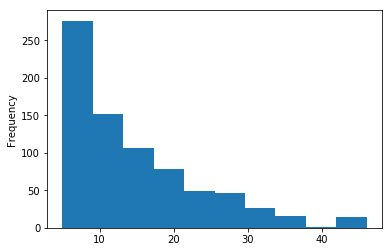

In [17]:
print (df.shape)
print (df.Sentiment.value_counts())

df.num_words.plot.hist()
plt.show()

In [18]:
sentences = df.clean_text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
#sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.Sentiment.values

In [20]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

#tokenized_texts = [tokenizer.from_pretrained(sent) for sent in sentences]
input_ids = [tokenizer.encode(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (sentences[0])
print (tokenized_texts[0])
print (input_ids[0])

Model name 'become administrative burden excessive prior authorization thing also claim contract renew several year unable even find uhc contact would address thing claim issue one contact become time consume difficult billing staff usual comment big matter good feeling' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'become administrative burden excessive prior authorization thing also claim contract renew several year unable even find uhc contact would address thing claim issue one contact become time consume difficult billing staff usual comment big matter good feeling' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'always glad see new patient' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'always glad see new patient' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'solo practice increase patient load' was not found in model name list (xln

Model name 'difficult get procedure approve timely manner' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'difficult get procedure approve timely manner' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'suspect reimburse less high level care provide compare person pay send patient ' home duplicate care already do' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'suspect reimburse less high level care provide compare person pay send patient ' home duplicate care already do' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'bill carry bill department personal experience credentiale process take long first start renewal personal experience process specialist regard prior authorization medication discuss earlier unitedhealthcare person can not recall name' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'bill carry bi

Model name 'need able speak person solve issue ongoing issue can not get help would like personal representative flu vaccine reimburse' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'need able speak person solve issue ongoing issue can not get help would like personal representative flu vaccine reimburse' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'availability specialist better reimbursement well psycho benefit' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'availability specialist better reimbursement well psycho benefit' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'base insurance provider see patient' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'base insurance provider see patient' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'become administrative burden e

Model name 'first keep website phone representative update practice accept uhc discrepancy need make real time without delay second communicate specialist deficit patient care primary care physician lastly become competitive reimbursement rate physician near practice area drop uhc due bottom industry low reimbursement rate' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'first keep website phone representative update practice accept uhc discrepancy need make real time without delay second communicate specialist deficit patient care primary care physician lastly become competitive reimbursement rate physician near practice area drop uhc due bottom industry low reimbursement rate' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'burden clinician datum entry collection well learn hoop jump patient able get proper care' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'burden clinician 

Model name 'trouble processing network claim need improvement hospital patient see call doctor network approve authorizationnot able get network community' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'trouble processing network claim need improvement hospital patient see call doctor network approve authorizationnot able get network community' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'make sure patient get referral mean pcp can not set state -PRON- be contract administrator secretary numerous email discussion unitedhealthcare rep change contract make patient frustrate concerned get bill pay' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'make sure patient get referral mean pcp can not set state -PRON- be contract administrator secretary numerous email discussion unitedhealthcare rep change contract make patient frustrate concerned get bill pay' was a path or url but coul

Model name 'uhc one easy company authorization company able require call multiple different company authorization also entire process ivr nice work lot patient also part reduction plan uhc company ease service need authorize awesome' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'uhc one easy company authorization company able require call multiple different company authorization also entire process ivr nice work lot patient also part reduction plan uhc company ease service need authorize awesome' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'numerous issue unitedhealthcare unitedhealthcare community plan past two year error part unitedhealthcare take many month resolve' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'numerous issue unitedhealthcare unitedhealthcare community plan past two year error part unitedhealthcare take many month resolve' was a path or url but couldn't

Model name 'would like see uhc ppo' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'would like see uhc ppo' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'majority claim deny get authorization surgery difficult hard get anything approve patient' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'majority claim deny get authorization surgery difficult hard get anything approve patient' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'well coverage medication although new one prove efficacious achieve control chronic condition seem illogical medical director ask prescribe medication prove enough efficacious prior authorization one benefit patient approve' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'well coverage medication although new one prove efficacious achieve control chronic condition seem illogical medi

Model name 'get prior authorization approve timely manner find referral within network' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'get prior authorization approve timely manner find referral within network' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'reimbursement medical procedure lab xray' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'reimbursement medical procedure lab xray' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'get lot aarp medicare uhc mcr hmo patient request see can not since' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'get lot aarp medicare uhc mcr hmo patient request see can not since' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'credentiale contracting still take way long fix seem credentiale stop sometimes reason frustrating deal new pr

Model name 'well compensation fp 's primary care' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'well compensation fp 's primary care' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'concern regard inability get patient transition care' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'concern regard inability get patient transition care' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'become administrative burden excessive prior authorization thing also claim contract renew several year unable even find uhc contact would address thing claim issue one contact become time consume difficult billing staff usual comment big matter good feeling' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'become administrative burden excessive prior authorization thing also claim contract renew several year unable even find uhc

Model name 'trouble processing network claim need improvement hospital patient see call doctor network approve authorizationnot able get network community' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'trouble processing network claim need improvement hospital patient see call doctor network approve authorizationnot able get network community' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'poor reimbursement extremely low customer service patient patient can not go miami valley hospital' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'poor reimbursement extremely low customer service patient patient can not go miami valley hospital' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'honestly uhc help get way practice medicine useless cost save maneuver red tape prior authorization money time spend deny care could much better spend care help pat

Model name 'simply preauthorization process main thing really obstruct care patient wish patient would information service proceed without prior authorization' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'simply preauthorization process main thing really obstruct care patient wish patient would information service proceed without prior authorization' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'uhc pay claim quick process' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'uhc pay claim quick process' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'website information always match customer service representative see side mostly concern cob' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'website information always match customer service representative see side mostly concern cob' was a path or url but coul

Model name 'ease process precertification surgery need faster' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'ease process precertification surgery need faster' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'reimbursement contracting availability help answer question' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'reimbursement contracting availability help answer question' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'formulary coverage medication coverage poor' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'formulary coverage medication coverage poor' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'sometime code uhc follow cpt guideline especially modifier need contract quest lab cozar' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assum

Model name 'patient happy precertification turnaround time staff can not speak nurse review surgical case customer service poor' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'patient happy precertification turnaround time staff can not speak nurse review surgical case customer service poor' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'increase fee schedule streamline prior authorization request dedicated phone representative available speak physician office representative without transfer numerous time representative speak english' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'increase fee schedule streamline prior authorization request dedicated phone representative available speak physician office representative without transfer numerous time representative speak english' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'increase timely 

Model name 'please send human office explain discuss fee schedule contract' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'please send human office explain discuss fee schedule contract' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'love new patient unitedhealthcare easy physician friendly insurance' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'love new patient unitedhealthcare easy physician friendly insurance' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'take care transgender patient many road block medication provision uhc also patient lied doctor get prior authorization pharmacy contact uhc simply refuse cover injectable estradiol' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'take care transgender patient many road block medication provision uhc also patient lied doctor get prior authorization

Model name 'due low reimbursement rate unable perform certain surgical procedure onsite asc mean many patient go hospital procedure therefore increase cost reimbursement many insurance make difficult -PRON- see new unitedhealthcare patient reimbursement even cover cost' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'due low reimbursement rate unable perform certain surgical procedure onsite asc mean many patient go hospital procedure therefore increase cost reimbursement many insurance make difficult -PRON- see new unitedhealthcare patient reimbursement even cover cost' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'get new doctor credentiale patient like home nurse visit inaccurate recommendation home nurse visit' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'get new doctor credentiale patient like home nurse visit inaccurate recommendation home nurse visit' was a path or ur

Model name 'get approval medication work extend claim submission window retroactively knowledgeable rep answer in verify call always live person available transfer call automate rep answer question' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'get approval medication work extend claim submission window retroactively knowledgeable rep answer in verify call always live person available transfer call automate rep answer question' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'decline reimbursement high deductible patient administrative burden prior authorization need address premium designation need overhaul' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'decline reimbursement high deductible patient administrative burden prior authorization need address premium designation need overhaul' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'patien

Model name 'prior authorization referral specialty area' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'prior authorization referral specialty area' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'complex prior authorization system poor formulary' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'complex prior authorization system poor formulary' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'better reimbursement well reimbursement well reimbursement network specialist particularly large popular orthopedic practice area refuse deal uhc less prior authorization reward -PRON- deem quality physician highly rate relax need prior authorization cts mris etc always get request waste money time money hoop jump' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'better reimbursement well reimbursement well reimbursement 

Model name 'unitedhealthcare medicare secondary insurance recognize pay medicare chronic care practice rarely ever receive denial unitedhealthcare prior authorization sure place retrospective review' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'unitedhealthcare medicare secondary insurance recognize pay medicare chronic care practice rarely ever receive denial unitedhealthcare prior authorization sure place retrospective review' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'radiology prior authorization image medication' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'radiology prior authorization image medication' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'could include -PRON- process take care patient instead dictate -PRON- can not pay -PRON- less plan' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assum

Model name 'need specialist actually see patient pharmacy formulary need united insurance carrier insurance formulary totally madness every day practice universal formulary' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'need specialist actually see patient pharmacy formulary need united insurance carrier insurance formulary totally madness every day practice universal formulary' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'need referral authorization every patient see office become much work' was not found in model name list (xlnet-base-cased, xlnet-large-cased). We assumed 'need referral authorization every patient see office become much work' was a path or url but couldn't find tokenizer filesat this path or url.
Model name 'uhc 's customer service average communication uhc optum orthonet average none entity communicate provider representative communication average helpfulness far provider rep -PRON- have co

Tokenize the first sentence:
become administrative burden excessive prior authorization thing also claim contract renew several year unable even find uhc contact would address thing claim issue one contact become time consume difficult billing staff usual comment big matter good feeling
None
[401, 3665, 6078, 8172, 2114, 16023, 554, 77, 1857, 1298, 11622, 294, 119, 2806, 176, 278, 17, 3314, 369, 1056, 74, 1131, 554, 1857, 671, 65, 1056, 401, 92, 12950, 1132, 13998, 891, 3586, 1709, 534, 918, 195, 1803]


In [ ]:
tokenizer.from_pretrained

In [21]:
from collections import Counter

In [22]:
Counter([len(ids) for ids in input_ids])

Counter({5: 49,
         6: 53,
         7: 49,
         8: 50,
         9: 26,
         10: 44,
         11: 21,
         12: 44,
         13: 26,
         14: 27,
         15: 40,
         16: 19,
         17: 13,
         18: 19,
         19: 37,
         20: 15,
         21: 13,
         22: 15,
         23: 18,
         24: 15,
         25: 11,
         26: 4,
         27: 13,
         28: 10,
         29: 6,
         30: 14,
         31: 18,
         32: 11,
         33: 12,
         34: 7,
         35: 5,
         36: 3,
         37: 5,
         38: 6,
         39: 14,
         40: 5,
         41: 6,
         42: 4,
         44: 3,
         47: 7,
         51: 5,
         56: 4})

In [23]:
MAX_LEN = 56

In [24]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [25]:
input_ids

array([[  401,  3665,  6078, ...,     0,     0,     0],
       [  426,  5590,   197, ...,     0,     0,     0],
       [ 5029,  1211,   771, ...,     0,     0,     0],
       ...,
       [ 2114, 16023,   182, ...,     0,     0,     0],
       [ 8440, 16661,   920, ...,     0,     0,     0],
       [   74,   115,  5760, ...,     0,     0,     0]])

In [26]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [27]:
np.array(attention_masks)

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [28]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [29]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs,dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs,dtype=torch.long)
train_labels = torch.tensor(train_labels,dtype=torch.long)
validation_labels = torch.tensor(validation_labels,dtype=torch.long)
train_masks = torch.tensor(train_masks,dtype=torch.long)
validation_masks = torch.tensor(validation_masks,dtype=torch.long)

In [30]:
validation_inputs

tensor([[  426,  1957,   109,  ...,     0,     0,     0],
        [  143,  1208,  2603,  ...,     0,     0,     0],
        [ 1991,  1613,   539,  ...,     0,     0,     0],
        ...,
        [  426,   564,   109,  ...,     0,     0,     0],
        [  300,   934,   214,  ...,     0,     0,     0],
        [ 9114, 14881,  5589,  ...,     0,     0,     0]])

In [31]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [32]:
train_data.tensors

(tensor([[ 5046,    74,   870,  ...,     0,     0,     0],
         [  143,  3056,  2211,  ...,     0,     0,     0],
         [ 1857, 13095, 12704,  ...,     0,     0,     0],
         ...,
         [30870,    93, 21305,  ...,     0,     0,     0],
         [ 2018,   109,  2585,  ...,     0,     0,     0],
         [ 1007,   616,  1068,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [34]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)


  0%|▏                                                                | 1410048/467042463 [00:17<1:04:15, 120783.96B/s]

KeyboardInterrupt: 

In [35]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)



  0%|                                                                                     | 0/467042463 [00:00<?, ?B/s]

  0%|                                                                     | 1024/467042463 [00:00<35:14:28, 3681.30B/s]

  0%|                                                                    | 17408/467042463 [00:00<25:20:37, 5118.80B/s]

  0%|                                                                    | 34816/467042463 [00:00<18:23:26, 7053.81B/s]

  0%|                                                                    | 51200/467042463 [00:01<13:30:16, 9605.55B/s]

  0%|                                                                   | 55296/467042463 [00:01<12:07:39, 10696.13B/s]

  0%|                                                                    | 69632/467042463 [00:01<9:18:16, 13940.93B/s]

  0%|                                                                    | 87040/467042463 [00:01<7:09:12, 18132.40B/s]

  0%|                         

  1%|▊                                                                  | 5448704/467042463 [00:29<35:33, 216387.18B/s]

  1%|▊                                                                  | 5517312/467042463 [00:29<29:00, 265159.42B/s]

  1%|▊                                                                  | 5551104/467042463 [00:30<32:33, 236264.86B/s]

  1%|▊                                                                  | 5580800/467042463 [00:30<30:49, 249530.25B/s]

  1%|▊                                                                  | 5610496/467042463 [00:30<36:06, 212939.12B/s]

  1%|▊                                                                  | 5640192/467042463 [00:30<44:10, 174107.70B/s]

  1%|▊                                                                  | 5709824/467042463 [00:30<40:26, 190096.30B/s]

  1%|▊                                                                  | 5779456/467042463 [00:31<37:39, 204179.54B/s]

  1%|▊                          

  2%|█▌                                                                | 11134976/467042463 [00:54<35:34, 213633.82B/s]

  2%|█▌                                                                | 11175936/467042463 [00:54<32:36, 232990.32B/s]

  2%|█▌                                                                | 11202560/467042463 [00:54<35:43, 212708.31B/s]

  2%|█▌                                                                | 11245568/467042463 [00:54<39:03, 194498.81B/s]

  2%|█▌                                                                | 11297792/467042463 [00:54<32:20, 234859.20B/s]

  2%|█▌                                                                | 11326464/467042463 [00:55<36:54, 205811.23B/s]

  2%|█▌                                                                | 11367424/467042463 [00:55<31:39, 239912.05B/s]

  2%|█▌                                                                | 11397120/467042463 [00:55<35:51, 211810.07B/s]

  2%|█▌                         

  3%|██▏                                                              | 16154624/467042463 [01:19<3:10:16, 39495.35B/s]

  3%|██▎                                                              | 16172032/467042463 [01:19<2:55:35, 42795.84B/s]

  3%|██▎                                                              | 16189440/467042463 [01:20<3:01:17, 41449.67B/s]

  3%|██▎                                                              | 16206848/467042463 [01:20<2:43:35, 45928.91B/s]

  3%|██▎                                                              | 16224256/467042463 [01:20<2:31:14, 49681.11B/s]

  3%|██▎                                                              | 16241664/467042463 [01:21<2:22:21, 52775.50B/s]

  3%|██▎                                                              | 16259072/467042463 [01:21<2:16:01, 55232.87B/s]

  3%|██▎                                                              | 16276480/467042463 [01:21<1:50:35, 67930.62B/s]

  3%|██▎                        

  4%|██▊                                                               | 19862528/467042463 [01:41<32:24, 229940.41B/s]

  4%|██▊                                                               | 19888128/467042463 [01:41<35:04, 212453.62B/s]

  4%|██▊                                                               | 19932160/467042463 [01:41<38:30, 193546.80B/s]

  4%|██▊                                                               | 19984384/467042463 [01:41<32:13, 231201.35B/s]

  4%|██▊                                                               | 20012032/467042463 [01:42<35:45, 208332.13B/s]

  4%|██▊                                                               | 20054016/467042463 [01:42<31:38, 235464.47B/s]

  4%|██▊                                                               | 20081664/467042463 [01:42<35:59, 206958.17B/s]

  4%|██▊                                                               | 20123648/467042463 [01:42<31:55, 233343.80B/s]

  4%|██▊                        

  5%|███▎                                                            | 24423424/467042463 [02:12<1:02:25, 118175.41B/s]

  5%|███▎                                                            | 24458240/467042463 [02:12<1:00:58, 120983.93B/s]

  5%|███▎                                                            | 24493056/467042463 [02:12<1:00:12, 122515.26B/s]

  5%|███▍                                                              | 24527872/467042463 [02:13<59:39, 123614.36B/s]

  5%|███▍                                                              | 24580096/467042463 [02:13<54:43, 134753.53B/s]

  5%|███▍                                                              | 24614912/467042463 [02:13<55:22, 133166.88B/s]

  5%|███▍                                                              | 24667136/467042463 [02:13<51:35, 142898.86B/s]

  5%|███▍                                                              | 24701952/467042463 [02:14<52:43, 139825.47B/s]

  5%|███▍                       

  6%|████                                                             | 28879872/467042463 [02:50<1:15:04, 97282.19B/s]

  6%|████                                                             | 28897280/467042463 [02:50<1:28:48, 82228.74B/s]

  6%|████                                                             | 28932096/467042463 [02:51<1:20:22, 90854.06B/s]

  6%|███▉                                                            | 28965888/467042463 [02:51<1:03:54, 114243.64B/s]

  6%|███▉                                                            | 28982272/467042463 [02:51<1:09:02, 105749.76B/s]

  6%|████                                                             | 28996608/467042463 [02:51<1:28:01, 82939.03B/s]

  6%|████                                                             | 29019136/467042463 [02:51<1:29:33, 81514.03B/s]

  6%|████                                                             | 29053952/467042463 [02:52<1:20:47, 90361.97B/s]

  6%|████                       

  7%|████▍                                                           | 32274432/467042463 [03:32<1:05:57, 109861.87B/s]

  7%|████▍                                                           | 32291840/467042463 [03:32<1:11:41, 101060.61B/s]

  7%|████▍                                                           | 32326656/467042463 [03:33<1:07:57, 106619.59B/s]

  7%|████▌                                                             | 32360448/467042463 [03:33<54:39, 132548.66B/s]

  7%|████▍                                                           | 32377856/467042463 [03:33<1:01:52, 117094.94B/s]

  7%|████▌                                                            | 32396288/467042463 [03:33<1:18:10, 92657.70B/s]

  7%|████▌                                                            | 32431104/467042463 [03:34<1:48:41, 66640.13B/s]

  7%|████▌                                                            | 32483328/467042463 [03:34<1:29:27, 80962.10B/s]

  7%|████▌                      

  8%|████▉                                                           | 35668992/467042463 [04:07<1:05:06, 110423.34B/s]

  8%|████▉                                                           | 35703808/467042463 [04:08<1:02:37, 114780.17B/s]

  8%|████▉                                                           | 35738624/467042463 [04:08<1:01:47, 116346.69B/s]

  8%|█████                                                             | 35773440/467042463 [04:08<59:26, 120932.58B/s]

  8%|█████                                                             | 35808256/467042463 [04:08<48:33, 147992.53B/s]

  8%|█████                                                             | 35826688/467042463 [04:08<59:11, 121420.77B/s]

  8%|████▉                                                            | 35860480/467042463 [04:09<1:21:46, 87878.68B/s]

  8%|████▉                                                           | 35912704/467042463 [04:09<1:09:01, 104110.78B/s]

  8%|█████                      

  8%|█████▍                                                           | 39497728/467042463 [04:47<1:23:08, 85706.03B/s]

  8%|█████▍                                                           | 39516160/467042463 [04:47<1:33:09, 76485.50B/s]

  8%|█████▌                                                           | 39533568/467042463 [04:47<1:38:54, 72036.23B/s]

  8%|█████▌                                                           | 39568384/467042463 [04:48<1:27:06, 81786.62B/s]

  8%|█████▌                                                           | 39585792/467042463 [04:48<1:34:33, 75338.40B/s]

  8%|█████▌                                                           | 39620608/467042463 [04:48<1:24:24, 84393.35B/s]

  8%|█████▌                                                           | 39638016/467042463 [04:48<1:32:16, 77192.41B/s]

  8%|█████▌                                                           | 39672832/467042463 [04:49<1:22:31, 86315.50B/s]

  8%|█████▌                     

  9%|██████▏                                                           | 43877376/467042463 [05:10<31:40, 222683.68B/s]

  9%|██████▏                                                           | 43920384/467042463 [05:10<29:06, 242312.78B/s]

  9%|██████▏                                                           | 43947008/467042463 [05:10<31:51, 221320.74B/s]

  9%|██████▏                                                           | 43972608/467042463 [05:10<33:10, 212513.09B/s]

  9%|██████▏                                                           | 44007424/467042463 [05:10<33:53, 208054.40B/s]

  9%|██████▏                                                           | 44042240/467042463 [05:10<30:23, 232029.08B/s]

  9%|██████▏                                                           | 44077056/467042463 [05:10<31:48, 221629.81B/s]

  9%|██████▏                                                           | 44111872/467042463 [05:11<28:59, 243170.80B/s]

  9%|██████▏                    

 10%|██████▊                                                           | 48342016/467042463 [05:29<29:21, 237732.33B/s]

 10%|██████▊                                                           | 48376832/467042463 [05:29<31:31, 221378.18B/s]

 10%|██████▊                                                           | 48411648/467042463 [05:29<28:28, 245006.08B/s]

 10%|██████▊                                                           | 48438272/467042463 [05:29<33:01, 211244.79B/s]

 10%|██████▊                                                           | 48463872/467042463 [05:29<31:50, 219095.31B/s]

 10%|██████▊                                                           | 48498688/467042463 [05:29<32:50, 212428.66B/s]

 10%|██████▊                                                           | 48532480/467042463 [05:30<29:57, 232787.41B/s]

 10%|██████▊                                                           | 48568320/467042463 [05:30<31:23, 222155.71B/s]

 10%|██████▊                    

 11%|███████▍                                                          | 52840448/467042463 [05:48<32:13, 214262.08B/s]

 11%|███████▍                                                          | 52885504/467042463 [05:48<30:04, 229563.66B/s]

 11%|███████▍                                                          | 52910080/467042463 [05:49<32:53, 209825.10B/s]

 11%|███████▍                                                          | 52955136/467042463 [05:49<34:20, 200950.74B/s]

 11%|███████▍                                                          | 53007360/467042463 [05:49<29:46, 231792.63B/s]

 11%|███████▍                                                          | 53032960/467042463 [05:49<33:39, 204992.93B/s]

 11%|███████▌                                                          | 53076992/467042463 [05:49<30:18, 227623.03B/s]

 11%|███████▌                                                          | 53102592/467042463 [05:49<32:25, 212773.30B/s]

 11%|███████▌                   

 12%|████████                                                          | 56889344/467042463 [06:15<41:00, 166678.41B/s]

 12%|████████                                                          | 56907776/467042463 [06:15<48:27, 141063.15B/s]

 12%|████████                                                          | 56941568/467042463 [06:15<40:16, 169722.54B/s]

 12%|████████                                                          | 56963072/467042463 [06:15<45:24, 150539.81B/s]

 12%|████████                                                          | 56993792/467042463 [06:16<38:42, 176587.61B/s]

 12%|████████                                                          | 57016320/467042463 [06:16<38:31, 177386.56B/s]

 12%|████████                                                          | 57046016/467042463 [06:16<37:42, 181227.05B/s]

 12%|████████                                                          | 57066496/467042463 [06:16<39:04, 174887.48B/s]

 12%|████████                   

 13%|████████▋                                                         | 61450240/467042463 [06:35<29:40, 227818.09B/s]

 13%|████████▋                                                         | 61485056/467042463 [06:35<29:44, 227238.67B/s]

 13%|████████▋                                                         | 61510656/467042463 [06:36<28:44, 235122.25B/s]

 13%|████████▋                                                         | 61554688/467042463 [06:36<28:48, 234598.45B/s]

 13%|████████▋                                                         | 61589504/467042463 [06:36<27:38, 244404.43B/s]

 13%|████████▋                                                         | 61615104/467042463 [06:36<31:02, 217680.98B/s]

 13%|████████▋                                                         | 61641728/467042463 [06:36<30:35, 220888.36B/s]

 13%|████████▋                                                         | 61676544/467042463 [06:36<31:43, 212994.85B/s]

 13%|████████▋                  

 14%|█████████▎                                                        | 66232320/467042463 [06:56<32:39, 204595.51B/s]

 14%|█████████▎                                                        | 66257920/467042463 [06:56<30:49, 216753.02B/s]

 14%|█████████▎                                                        | 66289664/467042463 [06:56<36:40, 182086.28B/s]

 14%|█████████▍                                                        | 66359296/467042463 [06:57<34:05, 195901.51B/s]

 14%|█████████▍                                                        | 66411520/467042463 [06:57<34:14, 194972.28B/s]

 14%|█████████▍                                                        | 66481152/467042463 [06:57<32:08, 207710.69B/s]

 14%|█████████▍                                                        | 66550784/467042463 [06:58<30:53, 216026.69B/s]

 14%|█████████▍                                                        | 66620416/467042463 [06:58<30:11, 221012.96B/s]

 14%|█████████▍                 

 15%|██████████                                                        | 71608320/467042463 [07:29<30:10, 218359.44B/s]

 15%|██████████                                                        | 71633920/467042463 [07:29<35:27, 185886.63B/s]

 15%|██████████▏                                                       | 71668736/467042463 [07:29<30:38, 215024.40B/s]

 15%|██████████▏                                                       | 71703552/467042463 [07:29<33:00, 199651.20B/s]

 15%|██████████▏                                                       | 71755776/467042463 [07:29<27:29, 239645.55B/s]

 15%|██████████▏                                                       | 71785472/467042463 [07:30<33:05, 199042.87B/s]

 15%|██████████▏                                                       | 71841792/467042463 [07:30<27:06, 242940.95B/s]

 15%|██████████▏                                                       | 71874560/467042463 [07:30<31:30, 208977.07B/s]

 15%|██████████▏                

 16%|██████████▊                                                       | 76072960/467042463 [07:48<31:28, 207019.52B/s]

 16%|██████████▊                                                       | 76107776/467042463 [07:48<28:24, 229371.25B/s]

 16%|██████████▊                                                       | 76133376/467042463 [07:48<32:11, 202393.04B/s]

 16%|██████████▊                                                       | 76160000/467042463 [07:49<29:57, 217477.75B/s]

 16%|██████████▊                                                       | 76194816/467042463 [07:49<31:15, 208345.15B/s]

 16%|██████████▊                                                       | 76229632/467042463 [07:49<27:40, 235388.87B/s]

 16%|██████████▊                                                       | 76264448/467042463 [07:49<29:48, 218451.78B/s]

 16%|██████████▊                                                       | 76314624/467042463 [07:49<24:46, 262927.91B/s]

 16%|██████████▊                

 17%|███████████▌                                                      | 81434624/467042463 [08:14<35:12, 182552.25B/s]

 17%|███████████▌                                                      | 81486848/467042463 [08:14<28:23, 226288.87B/s]

 17%|███████████▌                                                      | 81517568/467042463 [08:14<32:00, 200788.13B/s]

 17%|███████████▌                                                      | 81556480/467042463 [08:14<27:24, 234465.91B/s]

 17%|███████████▌                                                      | 81586176/467042463 [08:14<32:22, 198394.88B/s]

 17%|███████████▌                                                      | 81626112/467042463 [08:14<28:08, 228297.68B/s]

 17%|███████████▌                                                      | 81654784/467042463 [08:15<31:25, 204434.44B/s]

 17%|███████████▌                                                      | 81695744/467042463 [08:15<34:09, 188028.22B/s]

 18%|███████████▌               

 19%|████████████▏                                                     | 86569984/467042463 [08:36<28:43, 220754.47B/s]

 19%|████████████▏                                                     | 86604800/467042463 [08:36<26:26, 239786.61B/s]

 19%|████████████▏                                                     | 86639616/467042463 [08:36<27:53, 227330.60B/s]

 19%|████████████▏                                                     | 86674432/467042463 [08:36<25:42, 246545.37B/s]

 19%|████████████▎                                                     | 86709248/467042463 [08:37<29:35, 214240.78B/s]

 19%|████████████▎                                                     | 86761472/467042463 [08:37<29:09, 217354.59B/s]

 19%|████████████▎                                                     | 86796288/467042463 [08:37<26:05, 242966.07B/s]

 19%|████████████▎                                                     | 86831104/467042463 [08:37<29:05, 217857.94B/s]

 19%|████████████▎              

 19%|████████████▊                                                     | 90469376/467042463 [09:12<43:13, 145212.31B/s]

 19%|████████████▊                                                     | 90504192/467042463 [09:12<35:52, 174939.82B/s]

 19%|████████████▊                                                     | 90526720/467042463 [09:12<41:04, 152793.26B/s]

 19%|████████████▊                                                     | 90572800/467042463 [09:12<32:50, 191049.91B/s]

 19%|████████████▊                                                     | 90600448/467042463 [09:12<40:45, 153942.37B/s]

 19%|████████████▊                                                     | 90626048/467042463 [09:13<44:02, 142446.24B/s]

 19%|████████████▊                                                     | 90660864/467042463 [09:13<36:26, 172099.95B/s]

 19%|████████████▊                                                     | 90684416/467042463 [09:13<39:58, 156933.33B/s]

 19%|████████████▊              

 20%|█████████████▎                                                    | 94594048/467042463 [09:40<24:25, 254190.03B/s]

 20%|█████████████▎                                                    | 94623744/467042463 [09:40<28:05, 220935.13B/s]

 20%|█████████████▍                                                    | 94649344/467042463 [09:40<27:33, 225201.55B/s]

 20%|█████████████▍                                                    | 94681088/467042463 [09:40<26:15, 236300.70B/s]

 20%|█████████████▍                                                    | 94706688/467042463 [09:40<27:14, 227732.75B/s]

 20%|█████████████▍                                                    | 94734336/467042463 [09:40<30:09, 205732.70B/s]

 20%|█████████████▍                                                    | 94769152/467042463 [09:40<27:37, 224601.54B/s]

 20%|█████████████▍                                                    | 94803968/467042463 [09:41<28:24, 218330.34B/s]

 20%|█████████████▍             

 22%|██████████████                                                   | 101314560/467042463 [10:09<26:32, 229648.97B/s]

 22%|██████████████                                                   | 101383168/467042463 [10:09<25:19, 240576.08B/s]

 22%|██████████████                                                   | 101436416/467042463 [10:10<27:50, 218830.19B/s]

 22%|██████████████▏                                                  | 101506048/467042463 [10:10<27:10, 224244.08B/s]

 22%|██████████████▏                                                  | 101575680/467042463 [10:10<26:53, 226557.80B/s]

 22%|██████████████▏                                                  | 101645312/467042463 [10:10<26:21, 231035.26B/s]

 22%|██████████████▏                                                  | 101697536/467042463 [10:11<27:23, 222323.90B/s]

 22%|██████████████▏                                                  | 101767168/467042463 [10:11<26:38, 228471.80B/s]

 22%|██████████████▏            

 23%|██████████████▊                                                  | 106624000/467042463 [10:32<25:27, 236007.61B/s]

 23%|██████████████▊                                                  | 106658816/467042463 [10:32<26:55, 223084.89B/s]

 23%|██████████████▊                                                  | 106693632/467042463 [10:32<24:32, 244693.89B/s]

 23%|██████████████▊                                                  | 106728448/467042463 [10:32<26:44, 224606.08B/s]

 23%|██████████████▊                                                  | 106763264/467042463 [10:33<24:02, 249710.19B/s]

 23%|██████████████▊                                                  | 106798080/467042463 [10:33<26:02, 230543.64B/s]

 23%|██████████████▊                                                  | 106832896/467042463 [10:33<23:39, 253672.19B/s]

 23%|██████████████▊                                                  | 106860544/467042463 [10:33<26:10, 229312.27B/s]

 23%|██████████████▉            

 24%|███████████████▍                                                 | 111028224/467042463 [10:51<25:08, 236057.84B/s]

 24%|███████████████▍                                                 | 111063040/467042463 [10:51<24:56, 237926.11B/s]

 24%|███████████████▍                                                 | 111097856/467042463 [10:51<25:55, 228869.72B/s]

 24%|███████████████▍                                                 | 111121408/467042463 [10:51<26:27, 224162.78B/s]

 24%|███████████████▍                                                 | 111150080/467042463 [10:52<25:59, 228139.96B/s]

 24%|███████████████▍                                                 | 111184896/467042463 [10:52<26:36, 222947.06B/s]

 24%|███████████████▍                                                 | 111219712/467042463 [10:52<25:02, 236882.92B/s]

 24%|███████████████▍                                                 | 111254528/467042463 [10:52<25:50, 229443.68B/s]

 24%|███████████████▍           

 25%|████████████████                                                 | 115415040/467042463 [11:10<26:18, 222824.94B/s]

 25%|████████████████                                                 | 115449856/467042463 [11:10<24:47, 236367.18B/s]

 25%|████████████████                                                 | 115484672/467042463 [11:10<27:01, 216855.24B/s]

 25%|████████████████                                                 | 115536896/467042463 [11:11<26:47, 218729.18B/s]

 25%|████████████████                                                 | 115571712/467042463 [11:11<25:09, 232772.66B/s]

 25%|████████████████                                                 | 115606528/467042463 [11:11<25:56, 225734.75B/s]

 25%|████████████████                                                 | 115641344/467042463 [11:11<24:20, 240524.83B/s]

 25%|████████████████                                                 | 115676160/467042463 [11:11<25:39, 228271.35B/s]

 25%|████████████████           

 26%|████████████████▋                                                | 119923712/467042463 [11:29<25:51, 223685.15B/s]

 26%|████████████████▋                                                | 119949312/467042463 [11:30<28:27, 203250.90B/s]

 26%|████████████████▋                                                | 119993344/467042463 [11:30<25:31, 226572.46B/s]

 26%|████████████████▋                                                | 120018944/467042463 [11:30<27:34, 209775.14B/s]

 26%|████████████████▋                                                | 120062976/467042463 [11:30<29:25, 196505.26B/s]

 26%|████████████████▋                                                | 120097792/467042463 [11:30<25:40, 225263.51B/s]

 26%|████████████████▋                                                | 120132608/467042463 [11:30<28:09, 205351.76B/s]

 26%|████████████████▋                                                | 120167424/467042463 [11:31<24:55, 231905.26B/s]

 26%|████████████████▋          

 27%|█████████████████▍                                               | 124989440/467042463 [11:52<28:18, 201444.17B/s]

 27%|█████████████████▍                                               | 125041664/467042463 [11:52<24:23, 233651.98B/s]

 27%|█████████████████▍                                               | 125069312/467042463 [11:52<28:13, 201929.89B/s]

 27%|█████████████████▍                                               | 125111296/467042463 [11:52<29:10, 195336.90B/s]

 27%|█████████████████▍                                               | 125163520/467042463 [11:52<24:24, 233481.34B/s]

 27%|█████████████████▍                                               | 125192192/467042463 [11:53<27:04, 210468.91B/s]

 27%|█████████████████▍                                               | 125217792/467042463 [11:53<26:04, 218513.16B/s]

 27%|█████████████████▍                                               | 125250560/467042463 [11:53<27:54, 204070.07B/s]

 27%|█████████████████▍         

 28%|█████████████████▋                                              | 129428480/467042463 [12:13<1:20:53, 69556.82B/s]

 28%|█████████████████▋                                              | 129463296/467042463 [12:13<1:10:35, 79698.36B/s]

 28%|██████████████████▎                                               | 129515520/467042463 [12:14<58:35, 96004.12B/s]

 28%|██████████████████                                               | 129585152/467042463 [12:14<48:15, 116527.41B/s]

 28%|██████████████████                                               | 129637376/467042463 [12:14<37:14, 150994.59B/s]

 28%|██████████████████                                               | 129664000/467042463 [12:14<37:54, 148353.28B/s]

 28%|██████████████████                                               | 129707008/467042463 [12:14<35:37, 157849.72B/s]

 28%|██████████████████                                               | 129741824/467042463 [12:14<30:30, 184245.50B/s]

 28%|██████████████████         

 29%|██████████████████▋                                              | 134006784/467042463 [12:33<23:55, 232014.57B/s]

 29%|██████████████████▋                                              | 134041600/467042463 [12:33<22:31, 246308.10B/s]

 29%|██████████████████▋                                              | 134067200/467042463 [12:33<23:02, 240826.61B/s]

 29%|██████████████████▋                                              | 134093824/467042463 [12:33<25:03, 221490.12B/s]

 29%|██████████████████▋                                              | 134128640/467042463 [12:34<26:07, 212407.16B/s]

 29%|██████████████████▋                                              | 134163456/467042463 [12:34<23:53, 232227.44B/s]

 29%|██████████████████▋                                              | 134198272/467042463 [12:34<24:34, 225662.89B/s]

 29%|██████████████████▋                                              | 134233088/467042463 [12:34<23:25, 236865.99B/s]

 29%|██████████████████▋        

 30%|███████████████████▎                                             | 138504192/467042463 [12:52<24:28, 223667.17B/s]

 30%|███████████████████▎                                             | 138550272/467042463 [12:53<23:52, 229349.29B/s]

 30%|███████████████████▎                                             | 138573824/467042463 [12:53<24:15, 225724.77B/s]

 30%|███████████████████▎                                             | 138619904/467042463 [12:53<23:24, 233774.45B/s]

 30%|███████████████████▎                                             | 138644480/467042463 [12:53<23:31, 232727.41B/s]

 30%|███████████████████▎                                             | 138689536/467042463 [12:53<25:52, 211477.61B/s]

 30%|███████████████████▎                                             | 138741760/467042463 [12:53<23:56, 228494.56B/s]

 30%|███████████████████▎                                             | 138766336/467042463 [12:54<23:47, 229952.85B/s]

 30%|███████████████████▎       

 31%|████████████████████                                             | 144068608/467042463 [13:17<28:09, 191182.34B/s]

 31%|████████████████████                                             | 144120832/467042463 [13:17<23:25, 229731.82B/s]

 31%|████████████████████                                             | 144149504/467042463 [13:17<26:03, 206458.12B/s]

 31%|████████████████████                                             | 144175104/467042463 [13:17<24:49, 216731.06B/s]

 31%|████████████████████                                             | 144207872/467042463 [13:17<27:07, 198412.47B/s]

 31%|████████████████████                                             | 144242688/467042463 [13:17<23:39, 227448.63B/s]

 31%|████████████████████                                             | 144277504/467042463 [13:18<25:04, 214491.94B/s]

 31%|████████████████████                                             | 144329728/467042463 [13:18<21:15, 253083.76B/s]

 31%|████████████████████       

 32%|████████████████████▋                                            | 148542464/467042463 [13:36<23:59, 221195.07B/s]

 32%|████████████████████▋                                            | 148577280/467042463 [13:36<21:40, 244834.27B/s]

 32%|████████████████████▋                                            | 148603904/467042463 [13:36<24:22, 217752.81B/s]

 32%|████████████████████▋                                            | 148646912/467042463 [13:36<21:56, 241798.85B/s]

 32%|████████████████████▋                                            | 148673536/467042463 [13:37<25:23, 208957.72B/s]

 32%|████████████████████▋                                            | 148716544/467042463 [13:37<22:37, 234486.56B/s]

 32%|████████████████████▋                                            | 148743168/467042463 [13:37<25:44, 206088.01B/s]

 32%|████████████████████▋                                            | 148786176/467042463 [13:37<22:23, 236843.28B/s]

 32%|████████████████████▋      

 33%|████████████████████▉                                           | 152953856/467042463 [14:00<2:02:44, 42651.00B/s]

 33%|████████████████████▉                                           | 152964096/467042463 [14:00<2:10:01, 40256.15B/s]

 33%|████████████████████▉                                           | 152981504/467042463 [14:00<1:56:27, 44949.18B/s]

 33%|████████████████████▉                                           | 152998912/467042463 [14:00<1:46:46, 49019.12B/s]

 33%|████████████████████▉                                           | 153016320/467042463 [14:01<1:31:30, 57198.48B/s]

 33%|████████████████████▉                                           | 153033728/467042463 [14:01<1:25:17, 61365.57B/s]

 33%|████████████████████▉                                           | 153051136/467042463 [14:01<1:21:54, 63890.50B/s]

 33%|████████████████████▉                                           | 153068544/467042463 [14:01<1:20:25, 65068.51B/s]

 33%|████████████████████▉      

 33%|█████████████████████▋                                           | 156271616/467042463 [14:28<25:32, 202836.80B/s]

 33%|█████████████████████▊                                           | 156306432/467042463 [14:29<26:35, 194729.61B/s]

 33%|█████████████████████▊                                           | 156341248/467042463 [14:29<23:32, 219991.98B/s]

 33%|█████████████████████▊                                           | 156376064/467042463 [14:29<25:35, 202284.24B/s]

 33%|█████████████████████▊                                           | 156410880/467042463 [14:29<22:22, 231344.82B/s]

 33%|█████████████████████▊                                           | 156437504/467042463 [14:29<22:20, 231679.99B/s]

 34%|█████████████████████▊                                           | 156463104/467042463 [14:29<24:34, 210680.83B/s]

 34%|█████████████████████▊                                           | 156497920/467042463 [14:29<25:00, 206961.89B/s]

 34%|█████████████████████▊     

 34%|██████████████████████▎                                          | 160739328/467042463 [15:00<24:53, 205142.92B/s]

 34%|██████████████████████▍                                          | 160779264/467042463 [15:00<21:23, 238652.72B/s]

 34%|██████████████████████▍                                          | 160808960/467042463 [15:00<25:00, 204037.65B/s]

 34%|██████████████████████▍                                          | 160834560/467042463 [15:01<23:30, 217046.66B/s]

 34%|██████████████████████▍                                          | 160867328/467042463 [15:01<25:29, 200119.05B/s]

 34%|██████████████████████▍                                          | 160902144/467042463 [15:01<25:33, 199683.22B/s]

 34%|██████████████████████▍                                          | 160936960/467042463 [15:01<22:55, 222560.59B/s]

 34%|██████████████████████▍                                          | 160971776/467042463 [15:01<24:06, 211563.20B/s]

 34%|██████████████████████▍    

 35%|██████████████████████▉                                          | 164401152/467042463 [15:29<23:07, 218187.52B/s]

 35%|██████████████████████▉                                          | 164435968/467042463 [15:29<23:12, 217380.39B/s]

 35%|██████████████████████▉                                          | 164470784/467042463 [15:29<21:44, 231910.00B/s]

 35%|██████████████████████▉                                          | 164505600/467042463 [15:29<22:23, 225169.41B/s]

 35%|██████████████████████▉                                          | 164540416/467042463 [15:29<21:47, 231356.68B/s]

 35%|██████████████████████▉                                          | 164575232/467042463 [15:30<21:56, 229699.84B/s]

 35%|██████████████████████▉                                          | 164610048/467042463 [15:30<21:43, 231980.63B/s]

 35%|██████████████████████▉                                          | 164644864/467042463 [15:30<21:33, 233798.44B/s]

 35%|██████████████████████▉    

 36%|███████████████████████▍                                         | 168840192/467042463 [15:48<20:42, 239957.32B/s]

 36%|███████████████████████▌                                         | 168875008/467042463 [15:48<22:47, 218004.08B/s]

 36%|███████████████████████▌                                         | 168909824/467042463 [15:48<21:22, 232393.44B/s]

 36%|███████████████████████▌                                         | 168944640/467042463 [15:49<22:36, 219784.94B/s]

 36%|███████████████████████▌                                         | 168979456/467042463 [15:49<20:43, 239648.87B/s]

 36%|███████████████████████▌                                         | 169013248/467042463 [15:49<20:24, 243340.46B/s]

 36%|███████████████████████▌                                         | 169049088/467042463 [15:49<21:04, 235716.67B/s]

 36%|███████████████████████▌                                         | 169073664/467042463 [15:49<22:33, 220172.62B/s]

 36%|███████████████████████▌   

 37%|████████████████████████                                         | 172965888/467042463 [16:22<21:59, 222873.10B/s]

 37%|████████████████████████                                         | 173000704/467042463 [16:22<22:51, 214434.40B/s]

 37%|████████████████████████                                         | 173035520/467042463 [16:22<20:41, 236813.36B/s]

 37%|████████████████████████                                         | 173070336/467042463 [16:22<22:37, 216530.35B/s]

 37%|████████████████████████                                         | 173105152/467042463 [16:22<20:10, 242755.80B/s]

 37%|████████████████████████                                         | 173132800/467042463 [16:22<21:17, 229982.79B/s]

 37%|████████████████████████                                         | 173158400/467042463 [16:22<21:22, 229163.80B/s]

 37%|████████████████████████                                         | 173192192/467042463 [16:23<22:25, 218429.79B/s]

 37%|████████████████████████   

 38%|████████████████████████▋                                        | 177805312/467042463 [16:42<22:08, 217758.34B/s]

 38%|████████████████████████▋                                        | 177828864/467042463 [16:42<22:10, 217445.23B/s]

 38%|████████████████████████▊                                        | 177874944/467042463 [16:43<23:16, 207045.00B/s]

 38%|████████████████████████▊                                        | 177909760/467042463 [16:43<20:36, 233796.57B/s]

 38%|████████████████████████▊                                        | 177944576/467042463 [16:43<22:01, 218837.29B/s]

 38%|████████████████████████▊                                        | 177979392/467042463 [16:43<19:50, 242740.87B/s]

 38%|████████████████████████▊                                        | 178014208/467042463 [16:43<21:29, 224082.83B/s]

 38%|████████████████████████▊                                        | 178049024/467042463 [16:43<19:21, 248705.52B/s]

 38%|████████████████████████▊  

 39%|█████████████████████████▍                                       | 182467584/467042463 [17:05<21:45, 217922.03B/s]

 39%|█████████████████████████▍                                       | 182505472/467042463 [17:05<24:37, 192620.28B/s]

 39%|█████████████████████████▍                                       | 182557696/467042463 [17:05<20:42, 228880.47B/s]

 39%|█████████████████████████▍                                       | 182587392/467042463 [17:05<22:53, 207053.35B/s]

 39%|█████████████████████████▍                                       | 182627328/467042463 [17:05<19:49, 239055.21B/s]

 39%|█████████████████████████▍                                       | 182657024/467042463 [17:05<22:53, 207082.52B/s]

 39%|█████████████████████████▍                                       | 182714368/467042463 [17:06<23:16, 203665.58B/s]

 39%|█████████████████████████▍                                       | 182766592/467042463 [17:06<22:53, 206984.71B/s]

 39%|█████████████████████████▍ 

 40%|██████████████████████████                                       | 187362304/467042463 [17:26<21:23, 217882.51B/s]

 40%|██████████████████████████                                       | 187397120/467042463 [17:26<19:10, 243019.00B/s]

 40%|██████████████████████████                                       | 187431936/467042463 [17:26<21:05, 220897.12B/s]

 40%|██████████████████████████                                       | 187466752/467042463 [17:26<19:11, 242888.51B/s]

 40%|██████████████████████████                                       | 187493376/467042463 [17:26<21:14, 219290.10B/s]

 40%|██████████████████████████                                       | 187518976/467042463 [17:27<20:56, 222444.03B/s]

 40%|██████████████████████████                                       | 187553792/467042463 [17:27<21:57, 212211.12B/s]

 40%|██████████████████████████                                       | 187588608/467042463 [17:27<20:08, 231287.22B/s]

 40%|██████████████████████████ 

 41%|██████████████████████████▋                                      | 191946752/467042463 [17:46<20:07, 227821.87B/s]

 41%|██████████████████████████▋                                      | 191975424/467042463 [17:46<22:52, 200347.57B/s]

 41%|██████████████████████████▋                                      | 192010240/467042463 [17:46<20:54, 219302.03B/s]

 41%|██████████████████████████▋                                      | 192045056/467042463 [17:46<21:45, 210585.38B/s]

 41%|██████████████████████████▋                                      | 192079872/467042463 [17:46<20:31, 223227.10B/s]

 41%|██████████████████████████▋                                      | 192114688/467042463 [17:47<20:30, 223430.38B/s]

 41%|██████████████████████████▋                                      | 192149504/467042463 [17:47<19:38, 233327.82B/s]

 41%|██████████████████████████▋                                      | 192184320/467042463 [17:47<19:38, 233148.32B/s]

 41%|██████████████████████████▊

 42%|███████████████████████████▎                                     | 196518912/467042463 [18:06<18:46, 240182.31B/s]

 42%|███████████████████████████▎                                     | 196543488/467042463 [18:06<18:43, 240703.19B/s]

 42%|███████████████████████████▎                                     | 196571136/467042463 [18:06<19:26, 231809.23B/s]

 42%|███████████████████████████▎                                     | 196605952/467042463 [18:06<20:21, 221483.11B/s]

 42%|███████████████████████████▎                                     | 196640768/467042463 [18:06<18:35, 242426.43B/s]

 42%|███████████████████████████▎                                     | 196675584/467042463 [18:06<20:17, 222157.11B/s]

 42%|███████████████████████████▍                                     | 196710400/467042463 [18:06<19:50, 227126.31B/s]

 42%|███████████████████████████▍                                     | 196745216/467042463 [18:07<19:16, 233716.21B/s]

 42%|███████████████████████████

 43%|███████████████████████████▉                                     | 200999936/467042463 [18:25<19:48, 223813.66B/s]

 43%|███████████████████████████▉                                     | 201027584/467042463 [18:25<21:00, 210966.75B/s]

 43%|███████████████████████████▉                                     | 201062400/467042463 [18:25<20:15, 218760.93B/s]

 43%|███████████████████████████▉                                     | 201097216/467042463 [18:25<19:29, 227396.35B/s]

 43%|███████████████████████████▉                                     | 201132032/467042463 [18:26<19:36, 226019.16B/s]

 43%|███████████████████████████▉                                     | 201166848/467042463 [18:26<19:06, 231969.17B/s]

 43%|████████████████████████████                                     | 201200640/467042463 [18:26<17:56, 246861.41B/s]

 43%|████████████████████████████                                     | 201235456/467042463 [18:26<18:15, 242628.16B/s]

 43%|███████████████████████████

 44%|████████████████████████████▌                                    | 204926976/467042463 [18:51<31:52, 137056.49B/s]

 44%|████████████████████████████▌                                    | 204961792/467042463 [18:51<27:20, 159793.30B/s]

 44%|████████████████████████████▌                                    | 204980224/467042463 [18:51<31:18, 139513.85B/s]

 44%|████████████████████████████▌                                    | 205014016/467042463 [18:51<26:43, 163406.19B/s]

 44%|████████████████████████████▌                                    | 205033472/467042463 [18:51<30:22, 143728.00B/s]

 44%|████████████████████████████▌                                    | 205066240/467042463 [18:51<26:26, 165113.10B/s]

 44%|████████████████████████████▌                                    | 205086720/467042463 [18:52<28:54, 151010.25B/s]

 44%|████████████████████████████▉                                     | 205104128/467042463 [18:52<44:27, 98186.51B/s]

 44%|███████████████████████████

 45%|█████████████████████████████                                    | 208687104/467042463 [19:20<19:51, 216864.64B/s]

 45%|█████████████████████████████                                    | 208721920/467042463 [19:20<17:41, 243401.54B/s]

 45%|█████████████████████████████                                    | 208756736/467042463 [19:20<20:10, 213342.57B/s]

 45%|█████████████████████████████                                    | 208808960/467042463 [19:20<17:36, 244314.46B/s]

 45%|█████████████████████████████                                    | 208837632/467042463 [19:21<19:11, 224242.13B/s]

 45%|█████████████████████████████                                    | 208877568/467042463 [19:21<16:46, 256513.56B/s]

 45%|█████████████████████████████                                    | 208907264/467042463 [19:21<19:54, 216105.01B/s]

 45%|█████████████████████████████                                    | 208947200/467042463 [19:21<17:11, 250168.52B/s]

 45%|███████████████████████████

 46%|█████████████████████████████▋                                   | 213300224/467042463 [19:40<17:26, 242411.24B/s]

 46%|█████████████████████████████▋                                   | 213326848/467042463 [19:40<18:23, 230019.51B/s]

 46%|█████████████████████████████▋                                   | 213352448/467042463 [19:40<18:26, 229206.20B/s]

 46%|█████████████████████████████▋                                   | 213387264/467042463 [19:40<19:09, 220700.11B/s]

 46%|█████████████████████████████▋                                   | 213422080/467042463 [19:40<17:47, 237487.62B/s]

 46%|█████████████████████████████▋                                   | 213455872/467042463 [19:40<16:14, 260340.75B/s]

 46%|█████████████████████████████▋                                   | 213483520/467042463 [19:41<19:05, 221423.23B/s]

 46%|█████████████████████████████▋                                   | 213509120/467042463 [19:41<18:59, 222582.45B/s]

 46%|███████████████████████████

 47%|██████████████████████████████▎                                  | 217791488/467042463 [19:59<18:50, 220552.72B/s]

 47%|██████████████████████████████▎                                  | 217814016/467042463 [19:59<19:11, 216366.41B/s]

 47%|██████████████████████████████▎                                  | 217843712/467042463 [20:00<18:09, 228773.89B/s]

 47%|██████████████████████████████▎                                  | 217878528/467042463 [20:00<19:01, 218209.85B/s]

 47%|██████████████████████████████▎                                  | 217913344/467042463 [20:00<17:38, 235369.59B/s]

 47%|██████████████████████████████▎                                  | 217948160/467042463 [20:00<18:26, 225215.34B/s]

 47%|██████████████████████████████▎                                  | 217982976/467042463 [20:00<16:57, 244836.46B/s]

 47%|██████████████████████████████▎                                  | 218016768/467042463 [20:00<16:15, 255267.22B/s]

 47%|███████████████████████████

 47%|██████████████████████████████▊                                  | 221830144/467042463 [20:26<23:29, 173913.79B/s]

 48%|██████████████████████████████▉                                  | 221850624/467042463 [20:26<26:02, 156958.72B/s]

 48%|██████████████████████████████▉                                  | 221882368/467042463 [20:27<23:01, 177477.77B/s]

 48%|██████████████████████████████▉                                  | 221916160/467042463 [20:27<21:48, 187390.44B/s]

 48%|██████████████████████████████▉                                  | 221937664/467042463 [20:27<22:17, 183194.06B/s]

 48%|██████████████████████████████▉                                  | 221969408/467042463 [20:27<24:16, 168291.94B/s]

 48%|██████████████████████████████▉                                  | 222021632/467042463 [20:27<23:10, 176234.28B/s]

 48%|██████████████████████████████▉                                  | 222067712/467042463 [20:27<18:53, 216046.21B/s]

 48%|███████████████████████████

 48%|██████████████████████████████▉                                 | 226112512/467042463 [20:50<1:11:50, 55891.13B/s]

 48%|██████████████████████████████▉                                 | 226129920/467042463 [20:51<1:09:56, 57413.28B/s]

 48%|██████████████████████████████▉                                 | 226147328/467042463 [20:51<1:04:53, 61873.57B/s]

 48%|███████████████████████████████▉                                  | 226164736/467042463 [20:51<53:47, 74631.63B/s]

 48%|███████████████████████████████▉                                  | 226182144/467042463 [20:51<56:01, 71656.02B/s]

 48%|███████████████████████████████▉                                  | 226199552/467042463 [20:52<56:08, 71493.97B/s]

 48%|███████████████████████████████▉                                  | 226216960/467042463 [20:52<46:17, 86718.71B/s]

 48%|███████████████████████████████▉                                  | 226233344/467042463 [20:52<41:37, 96403.76B/s]

 48%|███████████████████████████

 49%|███████████████████████████████▉                                 | 229541888/467042463 [21:19<19:40, 201169.61B/s]

 49%|███████████████████████████████▉                                 | 229563392/467042463 [21:19<22:13, 178023.93B/s]

 49%|███████████████████████████████▉                                 | 229610496/467042463 [21:19<18:19, 215902.31B/s]

 49%|███████████████████████████████▉                                 | 229637120/467042463 [21:19<21:31, 183835.20B/s]

 49%|███████████████████████████████▉                                 | 229663744/467042463 [21:20<20:09, 196243.70B/s]

 49%|███████████████████████████████▉                                 | 229687296/467042463 [21:20<20:18, 194800.09B/s]

 49%|███████████████████████████████▉                                 | 229715968/467042463 [21:20<18:54, 209111.36B/s]

 49%|███████████████████████████████▉                                 | 229750784/467042463 [21:20<20:44, 190702.39B/s]

 49%|███████████████████████████

 50%|████████████████████████████████▌                                | 233881600/467042463 [21:40<20:34, 188937.98B/s]

 50%|████████████████████████████████▌                                | 233911296/467042463 [21:40<19:52, 195491.96B/s]

 50%|████████████████████████████████▌                                | 233932800/467042463 [21:40<21:16, 182574.75B/s]

 50%|████████████████████████████████▌                                | 233980928/467042463 [21:41<19:21, 200725.91B/s]

 50%|████████████████████████████████▌                                | 234002432/467042463 [21:41<19:09, 202698.17B/s]

 50%|████████████████████████████████▌                                | 234033152/467042463 [21:41<18:13, 213158.46B/s]

 50%|████████████████████████████████▌                                | 234067968/467042463 [21:41<18:21, 211513.18B/s]

 50%|████████████████████████████████▌                                | 234102784/467042463 [21:41<17:11, 225873.74B/s]

 50%|███████████████████████████

 51%|█████████████████████████████████▏                               | 238245888/467042463 [21:59<16:46, 227320.88B/s]

 51%|█████████████████████████████████▏                               | 238280704/467042463 [21:59<17:45, 214742.14B/s]

 51%|█████████████████████████████████▏                               | 238315520/467042463 [22:00<16:34, 229933.30B/s]

 51%|█████████████████████████████████▏                               | 238350336/467042463 [22:00<17:07, 222678.27B/s]

 51%|█████████████████████████████████▏                               | 238385152/467042463 [22:00<16:49, 226464.57B/s]

 51%|█████████████████████████████████▏                               | 238419968/467042463 [22:00<16:42, 228016.04B/s]

 51%|█████████████████████████████████▏                               | 238454784/467042463 [22:00<16:55, 225143.14B/s]

 51%|█████████████████████████████████▏                               | 238489600/467042463 [22:00<17:37, 216124.33B/s]

 51%|███████████████████████████

 52%|█████████████████████████████████▊                               | 242692096/467042463 [22:18<16:45, 223111.61B/s]

 52%|█████████████████████████████████▊                               | 242719744/467042463 [22:19<18:16, 204634.16B/s]

 52%|█████████████████████████████████▊                               | 242754560/467042463 [22:19<16:59, 219911.64B/s]

 52%|█████████████████████████████████▊                               | 242789376/467042463 [22:19<16:48, 222458.32B/s]

 52%|█████████████████████████████████▊                               | 242824192/467042463 [22:19<15:55, 234677.41B/s]

 52%|█████████████████████████████████▊                               | 242859008/467042463 [22:19<16:21, 228393.68B/s]

 52%|█████████████████████████████████▊                               | 242893824/467042463 [22:19<16:41, 223870.22B/s]

 52%|█████████████████████████████████▊                               | 242927616/467042463 [22:19<15:18, 243979.44B/s]

 52%|███████████████████████████

 53%|██████████████████████████████████▍                              | 247481344/467042463 [22:39<17:44, 206215.27B/s]

 53%|██████████████████████████████████▍                              | 247524352/467042463 [22:39<15:41, 233210.93B/s]

 53%|██████████████████████████████████▍                              | 247550976/467042463 [22:40<17:21, 210769.17B/s]

 53%|██████████████████████████████████▍                              | 247576576/467042463 [22:40<16:26, 222449.02B/s]

 53%|██████████████████████████████████▍                              | 247611392/467042463 [22:40<17:51, 204816.05B/s]

 53%|██████████████████████████████████▍                              | 247663616/467042463 [22:40<17:52, 204634.24B/s]

 53%|██████████████████████████████████▍                              | 247715840/467042463 [22:40<15:18, 238697.02B/s]

 53%|██████████████████████████████████▍                              | 247743488/467042463 [22:40<16:35, 220253.95B/s]

 53%|███████████████████████████

 54%|███████████████████████████████████                              | 251737088/467042463 [23:07<15:01, 238750.77B/s]

 54%|███████████████████████████████████                              | 251770880/467042463 [23:07<13:48, 259683.57B/s]

 54%|███████████████████████████████████                              | 251798528/467042463 [23:07<15:09, 236672.13B/s]

 54%|███████████████████████████████████                              | 251824128/467042463 [23:08<16:30, 217229.00B/s]

 54%|███████████████████████████████████                              | 251858944/467042463 [23:08<16:20, 219495.16B/s]

 54%|███████████████████████████████████                              | 251893760/467042463 [23:08<15:35, 229879.56B/s]

 54%|███████████████████████████████████                              | 251928576/467042463 [23:08<16:02, 223528.40B/s]

 54%|███████████████████████████████████                              | 251963392/467042463 [23:08<15:37, 229300.21B/s]

 54%|███████████████████████████

 55%|███████████████████████████████████▋                             | 256106496/467042463 [23:26<14:50, 236895.46B/s]

 55%|███████████████████████████████████▋                             | 256132096/467042463 [23:26<16:09, 217465.78B/s]

 55%|███████████████████████████████████▋                             | 256158720/467042463 [23:26<16:04, 218562.14B/s]

 55%|███████████████████████████████████▋                             | 256193536/467042463 [23:26<16:13, 216623.76B/s]

 55%|███████████████████████████████████▋                             | 256228352/467042463 [23:27<15:00, 234009.03B/s]

 55%|███████████████████████████████████▋                             | 256252928/467042463 [23:27<16:55, 207577.88B/s]

 55%|███████████████████████████████████▋                             | 256297984/467042463 [23:27<15:09, 231804.87B/s]

 55%|███████████████████████████████████▋                             | 256323584/467042463 [23:27<16:30, 212750.87B/s]

 55%|███████████████████████████

 56%|████████████████████████████████████▏                            | 260075520/467042463 [23:56<21:09, 163072.87B/s]

 56%|████████████████████████████████████▏                            | 260092928/467042463 [23:56<27:18, 126335.95B/s]

 56%|████████████████████████████████████▏                            | 260127744/467042463 [23:56<24:48, 139052.07B/s]

 56%|████████████████████████████████████▏                            | 260162560/467042463 [23:56<21:52, 157669.53B/s]

 56%|████████████████████████████████████▏                            | 260180992/467042463 [23:56<22:40, 152079.18B/s]

 56%|████████████████████████████████████▏                            | 260198400/467042463 [23:56<23:19, 147758.14B/s]

 56%|████████████████████████████████████▏                            | 260232192/467042463 [23:57<23:45, 145052.92B/s]

 56%|████████████████████████████████████▏                            | 260284416/467042463 [23:57<22:21, 154126.66B/s]

 56%|███████████████████████████

 57%|████████████████████████████████████▋                            | 263905280/467042463 [24:23<17:12, 196673.49B/s]

 57%|████████████████████████████████████▋                            | 263940096/467042463 [24:23<15:05, 224398.49B/s]

 57%|████████████████████████████████████▋                            | 263974912/467042463 [24:23<16:55, 199883.61B/s]

 57%|████████████████████████████████████▋                            | 264027136/467042463 [24:23<16:07, 209798.92B/s]

 57%|████████████████████████████████████▊                            | 264061952/467042463 [24:24<14:43, 229755.46B/s]

 57%|████████████████████████████████████▊                            | 264096768/467042463 [24:24<15:34, 217119.63B/s]

 57%|████████████████████████████████████▊                            | 264131584/467042463 [24:24<14:12, 237969.70B/s]

 57%|████████████████████████████████████▊                            | 264166400/467042463 [24:24<15:07, 223525.79B/s]

 57%|███████████████████████████

 57%|█████████████████████████████████████▎                           | 268431360/467042463 [24:42<15:00, 220625.04B/s]

 57%|█████████████████████████████████████▎                           | 268466176/467042463 [24:43<15:09, 218274.61B/s]

 57%|█████████████████████████████████████▎                           | 268500992/467042463 [24:43<14:02, 235594.50B/s]

 57%|█████████████████████████████████████▎                           | 268535808/467042463 [24:43<14:44, 224350.56B/s]

 58%|█████████████████████████████████████▍                           | 268570624/467042463 [24:43<13:30, 244887.12B/s]

 58%|█████████████████████████████████████▍                           | 268605440/467042463 [24:43<14:24, 229629.50B/s]

 58%|█████████████████████████████████████▍                           | 268640256/467042463 [24:43<13:41, 241586.52B/s]

 58%|█████████████████████████████████████▍                           | 268674048/467042463 [24:43<13:21, 247577.03B/s]

 58%|███████████████████████████

 58%|█████████████████████████████████████▉                           | 272835584/467042463 [25:01<14:27, 223877.98B/s]

 58%|█████████████████████████████████████▉                           | 272870400/467042463 [25:02<14:00, 230952.07B/s]

 58%|█████████████████████████████████████▉                           | 272904192/467042463 [25:02<13:44, 235505.86B/s]

 58%|█████████████████████████████████████▉                           | 272940032/467042463 [25:02<14:33, 222302.83B/s]

 58%|█████████████████████████████████████▉                           | 272962560/467042463 [25:02<14:30, 222977.92B/s]

 58%|█████████████████████████████████████▉                           | 273009664/467042463 [25:02<14:03, 229960.56B/s]

 58%|█████████████████████████████████████▉                           | 273033216/467042463 [25:02<14:05, 229455.69B/s]

 58%|██████████████████████████████████████                           | 273061888/467042463 [25:02<15:29, 208677.08B/s]

 58%|███████████████████████████

 60%|██████████████████████████████████████▊                          | 278727680/467042463 [25:27<11:34, 271000.65B/s]

 60%|██████████████████████████████████████▊                          | 278761472/467042463 [25:27<15:03, 208474.48B/s]

 60%|██████████████████████████████████████▊                          | 278806528/467042463 [25:27<16:42, 187797.66B/s]

 60%|██████████████████████████████████████▊                          | 278841344/467042463 [25:27<15:52, 197613.82B/s]

 60%|██████████████████████████████████████▊                          | 278876160/467042463 [25:28<15:41, 199819.92B/s]

 60%|██████████████████████████████████████▊                          | 278910976/467042463 [25:28<14:07, 222111.25B/s]

 60%|██████████████████████████████████████▊                          | 278945792/467042463 [25:28<15:01, 208630.58B/s]

 60%|██████████████████████████████████████▊                          | 278980608/467042463 [25:28<13:42, 228742.28B/s]

 60%|███████████████████████████

 61%|███████████████████████████████████████▍                         | 283158528/467042463 [25:46<13:46, 222517.26B/s]

 61%|███████████████████████████████████████▍                         | 283193344/467042463 [25:46<13:49, 221751.98B/s]

 61%|███████████████████████████████████████▍                         | 283228160/467042463 [25:46<12:55, 237017.12B/s]

 61%|███████████████████████████████████████▍                         | 283262976/467042463 [25:47<13:22, 228973.15B/s]

 61%|███████████████████████████████████████▍                         | 283297792/467042463 [25:47<12:42, 241030.57B/s]

 61%|███████████████████████████████████████▍                         | 283332608/467042463 [25:47<13:05, 233747.46B/s]

 61%|███████████████████████████████████████▍                         | 283367424/467042463 [25:47<13:17, 230431.93B/s]

 61%|███████████████████████████████████████▍                         | 283390976/467042463 [25:47<13:12, 231824.31B/s]

 61%|███████████████████████████

 62%|████████████████████████████████████████▏                        | 288833536/467042463 [26:11<13:14, 224326.57B/s]

 62%|████████████████████████████████████████▏                        | 288903168/467042463 [26:11<12:58, 228742.76B/s]

 62%|████████████████████████████████████████▏                        | 288972800/467042463 [26:11<12:46, 232356.51B/s]

 62%|████████████████████████████████████████▏                        | 289025024/467042463 [26:11<13:28, 220221.13B/s]

 62%|████████████████████████████████████████▏                        | 289094656/467042463 [26:12<13:07, 226099.92B/s]

 62%|████████████████████████████████████████▏                        | 289164288/467042463 [26:12<12:48, 231397.07B/s]

 62%|████████████████████████████████████████▎                        | 289232896/467042463 [26:12<11:07, 266537.06B/s]

 62%|████████████████████████████████████████▎                        | 289262592/467042463 [26:12<12:16, 241470.17B/s]

 62%|███████████████████████████

 63%|████████████████████████████████████████▉                        | 294525952/467042463 [26:35<11:38, 247081.26B/s]

 63%|████████████████████████████████████████▉                        | 294560768/467042463 [26:36<12:39, 227198.21B/s]

 63%|████████████████████████████████████████▉                        | 294595584/467042463 [26:36<11:36, 247441.80B/s]

 63%|█████████████████████████████████████████                        | 294622208/467042463 [26:36<11:24, 251993.07B/s]

 63%|█████████████████████████████████████████                        | 294648832/467042463 [26:36<11:45, 244328.61B/s]

 63%|█████████████████████████████████████████                        | 294681600/467042463 [26:36<11:35, 247995.24B/s]

 63%|█████████████████████████████████████████                        | 294707200/467042463 [26:36<12:37, 227605.72B/s]

 63%|█████████████████████████████████████████                        | 294734848/467042463 [26:36<13:38, 210413.37B/s]

 63%|███████████████████████████

 64%|█████████████████████████████████████████▌                       | 298931200/467042463 [26:54<14:54, 187886.68B/s]

 64%|█████████████████████████████████████████▌                       | 298982400/467042463 [26:55<12:47, 219028.10B/s]

 64%|█████████████████████████████████████████▌                       | 299009024/467042463 [26:55<13:30, 207332.49B/s]

 64%|█████████████████████████████████████████▌                       | 299052032/467042463 [26:55<12:53, 217052.35B/s]

 64%|█████████████████████████████████████████▌                       | 299076608/467042463 [26:55<12:52, 217531.36B/s]

 64%|█████████████████████████████████████████▋                       | 299104256/467042463 [26:55<12:11, 229503.24B/s]

 64%|█████████████████████████████████████████▋                       | 299139072/467042463 [26:55<12:46, 219167.71B/s]

 64%|█████████████████████████████████████████▋                       | 299173888/467042463 [26:55<11:31, 242800.37B/s]

 64%|███████████████████████████

 65%|██████████████████████████████████████████▎                      | 303839232/467042463 [27:16<11:45, 231195.81B/s]

 65%|██████████████████████████████████████████▎                      | 303863808/467042463 [27:16<12:42, 213982.26B/s]

 65%|██████████████████████████████████████████▎                      | 303908864/467042463 [27:16<11:38, 233544.07B/s]

 65%|██████████████████████████████████████████▎                      | 303934464/467042463 [27:16<12:53, 210878.62B/s]

 65%|██████████████████████████████████████████▎                      | 303978496/467042463 [27:16<13:40, 198646.46B/s]

 65%|██████████████████████████████████████████▎                      | 304048128/467042463 [27:17<12:54, 210406.04B/s]

 65%|██████████████████████████████████████████▎                      | 304100352/467042463 [27:17<11:21, 239260.76B/s]

 65%|██████████████████████████████████████████▎                      | 304126976/467042463 [27:17<12:10, 222927.67B/s]

 65%|███████████████████████████

 66%|██████████████████████████████████████████▊                      | 307947520/467042463 [27:52<25:38, 103413.56B/s]

 66%|██████████████████████████████████████████▊                      | 307964928/467042463 [27:52<25:20, 104645.54B/s]

 66%|██████████████████████████████████████████▊                      | 307982336/467042463 [27:52<24:40, 107461.73B/s]

 66%|███████████████████████████████████████████▌                      | 307999744/467042463 [27:52<41:52, 63291.65B/s]

 66%|███████████████████████████████████████████▌                      | 308034560/467042463 [27:53<32:56, 80450.86B/s]

 66%|███████████████████████████████████████████▌                      | 308051968/467042463 [27:53<36:01, 73544.62B/s]

 66%|███████████████████████████████████████████▌                      | 308069376/467042463 [27:53<36:46, 72046.95B/s]

 66%|███████████████████████████████████████████▌                      | 308086784/467042463 [27:53<34:23, 77018.27B/s]

 66%|███████████████████████████

 67%|███████████████████████████████████████████▎                     | 311568384/467042463 [28:13<12:49, 202031.77B/s]

 67%|███████████████████████████████████████████▎                     | 311620608/467042463 [28:13<10:49, 239452.26B/s]

 67%|███████████████████████████████████████████▎                     | 311649280/467042463 [28:13<12:30, 207064.82B/s]

 67%|███████████████████████████████████████████▍                     | 311690240/467042463 [28:13<10:53, 237648.89B/s]

 67%|███████████████████████████████████████████▍                     | 311718912/467042463 [28:13<12:25, 208466.03B/s]

 67%|███████████████████████████████████████████▍                     | 311759872/467042463 [28:13<11:27, 225731.63B/s]

 67%|███████████████████████████████████████████▍                     | 311785472/467042463 [28:14<12:18, 210312.21B/s]

 67%|███████████████████████████████████████████▍                     | 311829504/467042463 [28:14<11:23, 227179.97B/s]

 67%|███████████████████████████

 68%|████████████████████████████████████████████                     | 316471296/467042463 [28:34<13:26, 186741.96B/s]

 68%|████████████████████████████████████████████                     | 316512256/467042463 [28:34<11:25, 219585.77B/s]

 68%|████████████████████████████████████████████                     | 316540928/467042463 [28:34<12:33, 199742.57B/s]

 68%|████████████████████████████████████████████                     | 316581888/467042463 [28:34<10:59, 228306.47B/s]

 68%|████████████████████████████████████████████                     | 316610560/467042463 [28:34<12:23, 202425.13B/s]

 68%|████████████████████████████████████████████                     | 316651520/467042463 [28:35<10:38, 235430.63B/s]

 68%|████████████████████████████████████████████                     | 316680192/467042463 [28:35<13:07, 190882.91B/s]

 68%|████████████████████████████████████████████                     | 316737536/467042463 [28:35<12:08, 206462.01B/s]

 68%|███████████████████████████

 69%|████████████████████████████████████████████▋                    | 321142784/467042463 [28:54<10:33, 230226.42B/s]

 69%|████████████████████████████████████████████▋                    | 321177600/467042463 [28:54<11:07, 218611.83B/s]

 69%|████████████████████████████████████████████▋                    | 321212416/467042463 [28:54<10:01, 242586.17B/s]

 69%|████████████████████████████████████████████▋                    | 321247232/467042463 [28:55<11:10, 217469.17B/s]

 69%|████████████████████████████████████████████▋                    | 321299456/467042463 [28:55<09:53, 245367.79B/s]

 69%|████████████████████████████████████████████▋                    | 321327104/467042463 [28:55<10:26, 232531.65B/s]

 69%|████████████████████████████████████████████▋                    | 321369088/467042463 [28:55<09:55, 244669.98B/s]

 69%|████████████████████████████████████████████▋                    | 321395712/467042463 [28:55<11:01, 220013.08B/s]

 69%|███████████████████████████

 70%|█████████████████████████████████████████████▍                   | 326782976/467042463 [29:19<10:15, 227790.77B/s]

 70%|█████████████████████████████████████████████▍                   | 326807552/467042463 [29:19<11:07, 210048.63B/s]

 70%|█████████████████████████████████████████████▍                   | 326852608/467042463 [29:19<10:14, 228051.25B/s]

 70%|█████████████████████████████████████████████▍                   | 326877184/467042463 [29:19<10:44, 217352.22B/s]

 70%|█████████████████████████████████████████████▍                   | 326904832/467042463 [29:19<10:37, 219966.29B/s]

 70%|█████████████████████████████████████████████▌                   | 326939648/467042463 [29:19<11:20, 205733.26B/s]

 70%|█████████████████████████████████████████████▌                   | 326974464/467042463 [29:20<10:13, 228448.34B/s]

 70%|█████████████████████████████████████████████▌                   | 326999040/467042463 [29:20<11:01, 211753.64B/s]

 70%|███████████████████████████

 71%|█████████████████████████████████████████████▊                   | 329623552/467042463 [29:56<12:33, 182270.60B/s]

 71%|█████████████████████████████████████████████▉                   | 329655296/467042463 [29:56<13:59, 163640.85B/s]

 71%|█████████████████████████████████████████████▉                   | 329707520/467042463 [29:56<12:50, 178172.92B/s]

 71%|█████████████████████████████████████████████▉                   | 329742336/467042463 [29:56<11:03, 206911.51B/s]

 71%|█████████████████████████████████████████████▉                   | 329765888/467042463 [29:56<11:45, 194650.65B/s]

 71%|█████████████████████████████████████████████▉                   | 329787392/467042463 [29:56<11:33, 198007.64B/s]

 71%|█████████████████████████████████████████████▉                   | 329829376/467042463 [29:57<11:50, 193071.84B/s]

 71%|█████████████████████████████████████████████▉                   | 329864192/467042463 [29:57<10:26, 218940.23B/s]

 71%|███████████████████████████

 71%|█████████████████████████████████████████████▌                  | 332736512/467042463 [30:37<1:48:17, 20671.89B/s]

 71%|█████████████████████████████████████████████▌                  | 332753920/467042463 [30:37<1:38:04, 22819.94B/s]

 71%|█████████████████████████████████████████████▌                  | 332771328/467042463 [30:37<1:20:27, 27812.21B/s]

 71%|█████████████████████████████████████████████▌                  | 332788736/467042463 [30:38<1:17:29, 28877.58B/s]

 71%|█████████████████████████████████████████████▌                  | 332806144/467042463 [30:38<1:05:30, 34153.06B/s]

 71%|███████████████████████████████████████████████                   | 332823552/467042463 [30:39<57:00, 39240.21B/s]

 71%|███████████████████████████████████████████████                   | 332840960/467042463 [30:39<50:49, 44006.94B/s]

 71%|███████████████████████████████████████████████                   | 332858368/467042463 [30:39<46:32, 48056.79B/s]

 71%|███████████████████████████

 72%|███████████████████████████████████████████████▌                  | 336617472/467042463 [31:15<45:26, 47831.99B/s]

 72%|██████████████████████████████████████████████▏                 | 336629760/467042463 [31:15<1:03:43, 34109.04B/s]

 72%|██████████████████████████████████████████████▏                 | 336638976/467042463 [31:16<1:24:36, 25688.52B/s]

 72%|██████████████████████████████████████████████▏                 | 336653312/467042463 [31:16<1:18:32, 27667.28B/s]

 72%|██████████████████████████████████████████████▏                 | 336669696/467042463 [31:16<1:00:43, 35781.97B/s]

 72%|██████████████████████████████████████████████▏                 | 336677888/467042463 [31:17<1:05:19, 33260.43B/s]

 72%|██████████████████████████████████████████████▏                 | 336688128/467042463 [31:17<1:13:32, 29543.60B/s]

 72%|██████████████████████████████████████████████▏                 | 336705536/467042463 [31:17<1:02:17, 34875.68B/s]

 72%|███████████████████████████

 73%|████████████████████████████████████████████████                  | 339873792/467042463 [31:53<35:06, 60383.62B/s]

 73%|████████████████████████████████████████████████                  | 339891200/467042463 [31:53<28:50, 73475.15B/s]

 73%|████████████████████████████████████████████████                  | 339907584/467042463 [31:53<26:29, 80002.54B/s]

 73%|████████████████████████████████████████████████                  | 339926016/467042463 [31:54<29:41, 71343.19B/s]

 73%|████████████████████████████████████████████████                  | 339943424/467042463 [31:54<29:51, 70954.76B/s]

 73%|████████████████████████████████████████████████                  | 339977216/467042463 [31:54<23:00, 92013.74B/s]

 73%|████████████████████████████████████████████████                  | 339992576/467042463 [31:54<24:31, 86366.48B/s]

 73%|████████████████████████████████████████████████                  | 340005888/467042463 [31:55<29:13, 72449.70B/s]

 73%|███████████████████████████

 74%|████████████████████████████████████████████████                 | 345000960/467042463 [32:19<09:41, 209811.04B/s]

 74%|████████████████████████████████████████████████                 | 345043968/467042463 [32:20<12:43, 159744.20B/s]

 74%|████████████████████████████████████████████████                 | 345113600/467042463 [32:21<19:12, 105823.47B/s]

 74%|████████████████████████████████████████████████▊                 | 345131008/467042463 [32:21<33:10, 61258.66B/s]

 74%|████████████████████████████████████████████████▊                 | 345148416/467042463 [32:22<33:07, 61341.71B/s]

 74%|████████████████████████████████████████████████▊                 | 345183232/467042463 [32:22<28:49, 70471.33B/s]

 74%|████████████████████████████████████████████████▊                 | 345218048/467042463 [32:22<24:25, 83129.07B/s]

 74%|████████████████████████████████████████████████▊                 | 345270272/467042463 [32:23<20:50, 97411.87B/s]

 74%|███████████████████████████

 75%|████████████████████████████████████████████████▌                | 349221888/467042463 [32:47<08:58, 218901.82B/s]

 75%|████████████████████████████████████████████████▌                | 349256704/467042463 [32:47<08:12, 239045.88B/s]

 75%|████████████████████████████████████████████████▌                | 349290496/467042463 [32:47<07:30, 261239.40B/s]

 75%|████████████████████████████████████████████████▌                | 349318144/467042463 [32:47<08:30, 230513.27B/s]

 75%|████████████████████████████████████████████████▌                | 349343744/467042463 [32:47<09:07, 215016.04B/s]

 75%|████████████████████████████████████████████████▌                | 349378560/467042463 [32:47<09:11, 213300.33B/s]

 75%|████████████████████████████████████████████████▋                | 349413376/467042463 [32:47<08:45, 223724.07B/s]

 75%|████████████████████████████████████████████████▋                | 349448192/467042463 [32:48<08:51, 221082.81B/s]

 75%|███████████████████████████

 76%|█████████████████████████████████████████████████▏               | 353332224/467042463 [33:16<12:30, 151601.82B/s]

 76%|█████████████████████████████████████████████████▏               | 353364992/467042463 [33:16<12:44, 148639.32B/s]

 76%|█████████████████████████████████████████████████▏               | 353399808/467042463 [33:16<10:50, 174625.87B/s]

 76%|█████████████████████████████████████████████████▏               | 353420288/467042463 [33:17<12:34, 150581.06B/s]

 76%|█████████████████████████████████████████████████▏               | 353468416/467042463 [33:17<09:59, 189533.85B/s]

 76%|█████████████████████████████████████████████████▏               | 353496064/467042463 [33:17<11:48, 160264.87B/s]

 76%|█████████████████████████████████████████████████▏               | 353521664/467042463 [33:17<13:19, 141932.94B/s]

 76%|█████████████████████████████████████████████████▏               | 353556480/467042463 [33:17<11:02, 171196.40B/s]

 76%|███████████████████████████

 77%|█████████████████████████████████████████████████▊               | 357864448/467042463 [33:45<08:05, 224666.21B/s]

 77%|█████████████████████████████████████████████████▊               | 357891072/467042463 [33:46<08:28, 214785.58B/s]

 77%|█████████████████████████████████████████████████▊               | 357924864/467042463 [33:46<07:38, 238215.74B/s]

 77%|█████████████████████████████████████████████████▊               | 357960704/467042463 [33:46<08:21, 217375.95B/s]

 77%|█████████████████████████████████████████████████▊               | 357995520/467042463 [33:46<08:04, 225178.98B/s]

 77%|█████████████████████████████████████████████████▊               | 358030336/467042463 [33:46<08:21, 217183.79B/s]

 77%|█████████████████████████████████████████████████▊               | 358065152/467042463 [33:46<07:43, 235036.82B/s]

 77%|█████████████████████████████████████████████████▊               | 358099968/467042463 [33:47<08:21, 217232.54B/s]

 77%|███████████████████████████

 78%|██████████████████████████████████████████████████▍              | 362516480/467042463 [34:06<08:23, 207648.20B/s]

 78%|██████████████████████████████████████████████████▍              | 362556416/467042463 [34:06<07:24, 235256.91B/s]

 78%|██████████████████████████████████████████████████▍              | 362585088/467042463 [34:06<08:15, 210709.38B/s]

 78%|██████████████████████████████████████████████████▍              | 362626048/467042463 [34:06<09:02, 192403.65B/s]

 78%|██████████████████████████████████████████████████▍              | 362678272/467042463 [34:06<07:21, 236646.42B/s]

 78%|██████████████████████████████████████████████████▍              | 362710016/467042463 [34:06<08:17, 209568.16B/s]

 78%|██████████████████████████████████████████████████▍              | 362765312/467042463 [34:07<08:30, 204366.19B/s]

 78%|██████████████████████████████████████████████████▍              | 362834944/467042463 [34:07<08:09, 212859.30B/s]

 78%|███████████████████████████

 79%|███████████████████████████████████████████████████              | 367221760/467042463 [34:36<07:24, 224727.02B/s]

 79%|███████████████████████████████████████████████████              | 367256576/467042463 [34:36<06:38, 250519.51B/s]

 79%|███████████████████████████████████████████████████              | 367284224/467042463 [34:36<06:39, 249586.43B/s]

 79%|███████████████████████████████████████████████████              | 367310848/467042463 [34:36<07:24, 224359.39B/s]

 79%|███████████████████████████████████████████████████              | 367343616/467042463 [34:36<08:06, 204734.07B/s]

 79%|███████████████████████████████████████████████████▏             | 367395840/467042463 [34:36<07:13, 229604.85B/s]

 79%|███████████████████████████████████████████████████▏             | 367421440/467042463 [34:36<07:30, 221153.91B/s]

 79%|███████████████████████████████████████████████████▏             | 367464448/467042463 [34:37<06:27, 257136.80B/s]

 79%|███████████████████████████

 79%|███████████████████████████████████████████████████▌             | 370651136/467042463 [35:04<10:45, 149252.04B/s]

 79%|███████████████████████████████████████████████████▌             | 370703360/467042463 [35:05<10:09, 158178.86B/s]

 79%|███████████████████████████████████████████████████▌             | 370755584/467042463 [35:05<09:13, 173944.37B/s]

 79%|███████████████████████████████████████████████████▌             | 370790400/467042463 [35:05<08:13, 194983.93B/s]

 79%|███████████████████████████████████████████████████▌             | 370812928/467042463 [35:05<09:02, 177347.72B/s]

 79%|███████████████████████████████████████████████████▌             | 370842624/467042463 [35:05<08:14, 194497.30B/s]

 79%|███████████████████████████████████████████████████▌             | 370864128/467042463 [35:05<08:50, 181345.48B/s]

 79%|███████████████████████████████████████████████████▌             | 370884608/467042463 [35:06<08:50, 181254.89B/s]

 79%|███████████████████████████

 80%|████████████████████████████████████████████████████▏            | 375281664/467042463 [35:25<06:51, 222732.95B/s]

 80%|████████████████████████████████████████████████████▏            | 375316480/467042463 [35:25<06:50, 223703.06B/s]

 80%|████████████████████████████████████████████████████▏            | 375351296/467042463 [35:25<06:30, 234687.89B/s]

 80%|████████████████████████████████████████████████████▏            | 375386112/467042463 [35:25<07:00, 217888.38B/s]

 80%|████████████████████████████████████████████████████▏            | 375420928/467042463 [35:25<06:24, 238283.40B/s]

 80%|████████████████████████████████████████████████████▎            | 375455744/467042463 [35:25<06:44, 226164.80B/s]

 80%|████████████████████████████████████████████████████▎            | 375490560/467042463 [35:26<06:10, 247249.41B/s]

 80%|████████████████████████████████████████████████████▎            | 375525376/467042463 [35:26<07:00, 217878.51B/s]

 80%|███████████████████████████

 81%|████████████████████████████████████████████████████▊            | 379198464/467042463 [35:53<13:12, 110897.94B/s]

 81%|████████████████████████████████████████████████████▊            | 379233280/467042463 [35:54<12:46, 114611.20B/s]

 81%|████████████████████████████████████████████████████▊            | 379268096/467042463 [35:54<11:56, 122435.08B/s]

 81%|████████████████████████████████████████████████████▊            | 379302912/467042463 [35:54<10:10, 143642.79B/s]

 81%|████████████████████████████████████████████████████▊            | 379320320/467042463 [35:54<12:03, 121302.66B/s]

 81%|████████████████████████████████████████████████████▊            | 379355136/467042463 [35:55<11:48, 123679.19B/s]

 81%|████████████████████████████████████████████████████▊            | 379389952/467042463 [35:55<09:32, 153102.03B/s]

 81%|████████████████████████████████████████████████████▊            | 379410432/467042463 [35:55<11:20, 128722.19B/s]

 81%|███████████████████████████

 82%|█████████████████████████████████████████████████████▍           | 383579136/467042463 [36:24<06:35, 210959.45B/s]

 82%|█████████████████████████████████████████████████████▍           | 383604736/467042463 [36:25<06:20, 219350.67B/s]

 82%|█████████████████████████████████████████████████████▍           | 383637504/467042463 [36:25<06:41, 207857.35B/s]

 82%|█████████████████████████████████████████████████████▍           | 383672320/467042463 [36:25<05:59, 231615.77B/s]

 82%|█████████████████████████████████████████████████████▍           | 383697920/467042463 [36:25<06:45, 205369.05B/s]

 82%|█████████████████████████████████████████████████████▍           | 383741952/467042463 [36:25<06:02, 229719.83B/s]

 82%|█████████████████████████████████████████████████████▍           | 383767552/467042463 [36:25<06:55, 200494.28B/s]

 82%|█████████████████████████████████████████████████████▍           | 383811584/467042463 [36:25<06:01, 230009.35B/s]

 82%|███████████████████████████

 83%|██████████████████████████████████████████████████████▊           | 387902464/467042463 [36:48<28:24, 46440.88B/s]

 83%|██████████████████████████████████████████████████████▊           | 387919872/467042463 [36:48<26:18, 50135.87B/s]

 83%|██████████████████████████████████████████████████████▊           | 387937280/467042463 [36:48<24:00, 54919.48B/s]

 83%|██████████████████████████████████████████████████████▊           | 387954688/467042463 [36:49<22:16, 59163.14B/s]

 83%|██████████████████████████████████████████████████████▊           | 387972096/467042463 [36:49<21:42, 60696.58B/s]

 83%|██████████████████████████████████████████████████████▊           | 387989504/467042463 [36:49<21:35, 61015.21B/s]

 83%|██████████████████████████████████████████████████████▊           | 388006912/467042463 [36:50<20:57, 62864.73B/s]

 83%|██████████████████████████████████████████████████████▊           | 388041728/467042463 [36:50<18:11, 72406.73B/s]

 83%|███████████████████████████

 84%|██████████████████████████████████████████████████████▌          | 392115200/467042463 [37:11<05:16, 236794.95B/s]

 84%|██████████████████████████████████████████████████████▌          | 392139776/467042463 [37:11<05:17, 236154.05B/s]

 84%|██████████████████████████████████████████████████████▌          | 392184832/467042463 [37:11<05:11, 240152.15B/s]

 84%|██████████████████████████████████████████████████████▌          | 392209408/467042463 [37:11<05:11, 240013.69B/s]

 84%|██████████████████████████████████████████████████████▌          | 392237056/467042463 [37:11<05:53, 211734.72B/s]

 84%|██████████████████████████████████████████████████████▌          | 392271872/467042463 [37:12<05:57, 209106.17B/s]

 84%|██████████████████████████████████████████████████████▌          | 392306688/467042463 [37:12<05:29, 226786.20B/s]

 84%|██████████████████████████████████████████████████████▌          | 392341504/467042463 [37:12<05:34, 223111.13B/s]

 84%|███████████████████████████

 85%|███████████████████████████████████████████████████████▎         | 397842432/467042463 [37:35<04:27, 258317.23B/s]

 85%|███████████████████████████████████████████████████████▎         | 397874176/467042463 [37:36<05:12, 221531.39B/s]

 85%|███████████████████████████████████████████████████████▍         | 397929472/467042463 [37:36<05:31, 208589.89B/s]

 85%|███████████████████████████████████████████████████████▍         | 397981696/467042463 [37:36<04:51, 236955.57B/s]

 85%|███████████████████████████████████████████████████████▍         | 398009344/467042463 [37:36<05:06, 225032.96B/s]

 85%|███████████████████████████████████████████████████████▍         | 398051328/467042463 [37:36<05:36, 205136.16B/s]

 85%|███████████████████████████████████████████████████████▍         | 398103552/467042463 [37:37<04:37, 248602.02B/s]

 85%|███████████████████████████████████████████████████████▍         | 398134272/467042463 [37:37<05:17, 216990.92B/s]

 85%|███████████████████████████

 86%|███████████████████████████████████████████████████████▉         | 401828864/467042463 [38:10<09:37, 112980.89B/s]

 86%|███████████████████████████████████████████████████████▉         | 401846272/467042463 [38:10<09:19, 116534.11B/s]

 86%|███████████████████████████████████████████████████████▉         | 401863680/467042463 [38:10<09:22, 115789.20B/s]

 86%|███████████████████████████████████████████████████████▉         | 401881088/467042463 [38:11<09:15, 117400.28B/s]

 86%|███████████████████████████████████████████████████████▉         | 401898496/467042463 [38:11<09:04, 119696.84B/s]

 86%|███████████████████████████████████████████████████████▉         | 401915904/467042463 [38:11<08:59, 120665.56B/s]

 86%|███████████████████████████████████████████████████████▉         | 401949696/467042463 [38:11<07:39, 141754.76B/s]

 86%|████████████████████████████████████████████████████████▊         | 401966080/467042463 [38:11<14:14, 76116.25B/s]

 86%|███████████████████████████

 87%|████████████████████████████████████████████████████████▍        | 405347328/467042463 [38:33<06:58, 147397.81B/s]

 87%|████████████████████████████████████████████████████████▍        | 405365760/467042463 [38:33<08:02, 127890.57B/s]

 87%|████████████████████████████████████████████████████████▍        | 405414912/467042463 [38:34<07:24, 138798.90B/s]

 87%|████████████████████████████████████████████████████████▍        | 405467136/467042463 [38:34<06:49, 150185.64B/s]

 87%|████████████████████████████████████████████████████████▍        | 405519360/467042463 [38:34<06:27, 158944.71B/s]

 87%|████████████████████████████████████████████████████████▍        | 405571584/467042463 [38:35<06:10, 165926.09B/s]

 87%|████████████████████████████████████████████████████████▍        | 405606400/467042463 [38:35<05:21, 191268.23B/s]

 87%|████████████████████████████████████████████████████████▍        | 405627904/467042463 [38:35<06:05, 167998.28B/s]

 87%|███████████████████████████

 88%|██████████████████████████████████████████████████████████        | 411159552/467042463 [39:03<28:26, 32742.97B/s]

 88%|██████████████████████████████████████████████████████████        | 411176960/467042463 [39:03<28:07, 33106.54B/s]

 88%|██████████████████████████████████████████████████████████        | 411194368/467042463 [39:04<24:16, 38335.82B/s]

 88%|██████████████████████████████████████████████████████████        | 411211776/467042463 [39:04<21:34, 43128.67B/s]

 88%|██████████████████████████████████████████████████████████        | 411229184/467042463 [39:04<19:39, 47336.42B/s]

 88%|██████████████████████████████████████████████████████████        | 411246592/467042463 [39:05<18:19, 50757.06B/s]

 88%|██████████████████████████████████████████████████████████        | 411264000/467042463 [39:05<17:19, 53682.88B/s]

 88%|██████████████████████████████████████████████████████████        | 411281408/467042463 [39:05<16:37, 55916.88B/s]

 88%|███████████████████████████

 89%|█████████████████████████████████████████████████████████▊       | 415563776/467042463 [39:29<04:10, 205252.75B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415585280/467042463 [39:29<04:15, 201785.96B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415633408/467042463 [39:29<03:54, 219553.34B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415656960/467042463 [39:29<03:55, 218354.37B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415703040/467042463 [39:30<03:43, 229742.62B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415726592/467042463 [39:30<03:48, 224816.36B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415771648/467042463 [39:30<03:36, 236305.19B/s]

 89%|█████████████████████████████████████████████████████████▊       | 415796224/467042463 [39:30<03:45, 226937.22B/s]

 89%|███████████████████████████

 90%|███████████████████████████████████████████████████████████▎      | 419985408/467042463 [39:50<08:57, 87476.19B/s]

 90%|██████████████████████████████████████████████████████████▍      | 420055040/467042463 [39:51<07:14, 108093.76B/s]

 90%|██████████████████████████████████████████████████████████▍      | 420107264/467042463 [39:51<06:15, 124901.87B/s]

 90%|██████████████████████████████████████████████████████████▍      | 420176896/467042463 [39:51<05:20, 146039.39B/s]

 90%|██████████████████████████████████████████████████████████▍      | 420246528/467042463 [39:52<04:42, 165642.42B/s]

 90%|██████████████████████████████████████████████████████████▍      | 420316160/467042463 [39:52<04:16, 182264.40B/s]

 90%|██████████████████████████████████████████████████████████▌      | 420368384/467042463 [39:52<03:47, 204961.68B/s]

 90%|██████████████████████████████████████████████████████████▌      | 420392960/467042463 [39:52<03:39, 212707.48B/s]

 90%|███████████████████████████

 91%|███████████████████████████████████████████████████████████▏     | 425138176/467042463 [40:13<02:59, 233000.88B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425169920/467042463 [40:13<03:22, 206856.91B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425224192/467042463 [40:13<02:45, 253198.86B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425259008/467042463 [40:14<03:25, 203537.89B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425294848/467042463 [40:14<04:01, 173193.81B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425347072/467042463 [40:14<03:19, 209500.76B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425376768/467042463 [40:14<03:40, 188973.56B/s]

 91%|███████████████████████████████████████████████████████████▏     | 425402368/467042463 [40:14<03:34, 194377.35B/s]

 91%|███████████████████████████

 92%|███████████████████████████████████████████████████████████▊     | 429838336/467042463 [40:34<02:55, 212313.70B/s]

 92%|███████████████████████████████████████████████████████████▊     | 429873152/467042463 [40:34<02:46, 223526.05B/s]

 92%|███████████████████████████████████████████████████████████▊     | 429907968/467042463 [40:34<02:48, 219988.40B/s]

 92%|███████████████████████████████████████████████████████████▊     | 429942784/467042463 [40:35<02:40, 230737.98B/s]

 92%|███████████████████████████████████████████████████████████▊     | 429977600/467042463 [40:35<02:44, 224780.83B/s]

 92%|███████████████████████████████████████████████████████████▊     | 430012416/467042463 [40:35<02:34, 239114.46B/s]

 92%|███████████████████████████████████████████████████████████▊     | 430047232/467042463 [40:35<02:41, 228886.21B/s]

 92%|███████████████████████████████████████████████████████████▊     | 430082048/467042463 [40:35<02:31, 244310.54B/s]

 92%|███████████████████████████

 93%|████████████████████████████████████████████████████████████▌    | 435145728/467042463 [40:57<02:22, 223930.91B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435169280/467042463 [40:58<02:41, 196886.95B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435200000/467042463 [40:58<02:36, 202930.81B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435221504/467042463 [40:58<03:10, 166926.47B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435269632/467042463 [40:58<02:50, 186604.69B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435291136/467042463 [40:58<03:02, 173755.24B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435339264/467042463 [40:58<02:51, 184894.16B/s]

 93%|████████████████████████████████████████████████████████████▌    | 435359744/467042463 [40:59<02:47, 189254.00B/s]

 93%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████▏   | 439430144/467042463 [41:19<02:14, 205237.56B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439464960/467042463 [41:19<02:17, 200411.00B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439499776/467042463 [41:19<02:02, 224983.31B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439534592/467042463 [41:19<02:07, 215727.38B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439569408/467042463 [41:19<01:56, 236589.24B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439604224/467042463 [41:19<02:03, 221813.59B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439639040/467042463 [41:19<01:51, 245800.40B/s]

 94%|█████████████████████████████████████████████████████████████▏   | 439673856/467042463 [41:20<02:00, 226526.06B/s]

 94%|███████████████████████████

 95%|█████████████████████████████████████████████████████████████▋   | 443554816/467042463 [41:45<02:49, 138548.70B/s]

 95%|█████████████████████████████████████████████████████████████▋   | 443570176/467042463 [41:45<02:46, 141292.29B/s]

 95%|█████████████████████████████████████████████████████████████▋   | 443590656/467042463 [41:45<03:32, 110299.20B/s]

 95%|█████████████████████████████████████████████████████████████▋   | 443625472/467042463 [41:45<03:18, 118025.98B/s]

 95%|█████████████████████████████████████████████████████████████▋   | 443660288/467042463 [41:46<03:17, 118596.14B/s]

 95%|█████████████████████████████████████████████████████████████▋   | 443677696/467042463 [41:46<03:15, 119460.76B/s]

 95%|█████████████████████████████████████████████████████████████▊   | 443711488/467042463 [41:46<02:50, 136520.53B/s]

 95%|█████████████████████████████████████████████████████████████▊   | 443729920/467042463 [41:46<02:54, 133736.09B/s]

 95%|███████████████████████████

 96%|███████████████████████████████████████████████████████████████▎  | 447820800/467042463 [42:12<05:01, 63852.19B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447855616/467042463 [42:13<04:26, 72043.85B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447873024/467042463 [42:13<04:26, 71886.48B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447907840/467042463 [42:13<03:56, 81039.18B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447925248/467042463 [42:13<03:38, 87465.72B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447942656/467042463 [42:14<04:02, 78619.05B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447960064/467042463 [42:14<03:42, 85683.94B/s]

 96%|███████████████████████████████████████████████████████████████▎  | 447977472/467042463 [42:14<03:18, 95983.17B/s]

 96%|███████████████████████████

 97%|██████████████████████████████████████████████████████████████▉  | 451859456/467042463 [42:36<01:48, 140368.51B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 451911680/467042463 [42:36<01:41, 149583.07B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 451963904/467042463 [42:36<01:35, 158578.48B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 452016128/467042463 [42:37<01:31, 164196.88B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 452068352/467042463 [42:37<01:27, 171424.49B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 452120576/467042463 [42:37<01:25, 175054.79B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 452172800/467042463 [42:38<01:18, 188481.98B/s]

 97%|██████████████████████████████████████████████████████████████▉  | 452207616/467042463 [42:38<01:08, 217946.02B/s]

 97%|███████████████████████████

 98%|███████████████████████████████████████████████████████████████▌ | 456594432/467042463 [42:57<00:49, 211698.19B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456629248/467042463 [42:57<00:46, 224700.70B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456664064/467042463 [42:57<00:46, 225284.09B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456698880/467042463 [42:57<00:44, 233786.98B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456733696/467042463 [42:57<00:44, 231613.07B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456767488/467042463 [42:58<00:40, 254746.28B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456794112/467042463 [42:58<00:43, 238232.11B/s]

 98%|███████████████████████████████████████████████████████████████▌ | 456820736/467042463 [42:58<00:48, 212135.48B/s]

 98%|███████████████████████████

 99%|████████████████████████████████████████████████████████████████▏| 461503488/467042463 [43:20<00:24, 223350.86B/s]

 99%|████████████████████████████████████████████████████████████████▏| 461538304/467042463 [43:20<00:23, 239272.42B/s]

 99%|████████████████████████████████████████████████████████████████▏| 461572096/467042463 [43:21<00:21, 248797.58B/s]

 99%|████████████████████████████████████████████████████████████████▏| 461597696/467042463 [43:21<00:22, 237251.52B/s]

 99%|████████████████████████████████████████████████████████████████▏| 461625344/467042463 [43:21<00:25, 211339.25B/s]

 99%|████████████████████████████████████████████████████████████████▎| 461660160/467042463 [43:21<00:24, 223436.00B/s]

 99%|████████████████████████████████████████████████████████████████▎| 461694976/467042463 [43:21<00:24, 215476.81B/s]

 99%|████████████████████████████████████████████████████████████████▎| 461729792/467042463 [43:21<00:22, 239326.01B/s]

 99%|███████████████████████████

100%|████████████████████████████████████████████████████████████████▊| 466064384/467042463 [43:42<00:04, 222031.43B/s]

100%|████████████████████████████████████████████████████████████████▊| 466099200/467042463 [43:42<00:04, 214437.94B/s]

100%|████████████████████████████████████████████████████████████████▊| 466122752/467042463 [43:42<00:07, 125149.11B/s]

100%|████████████████████████████████████████████████████████████████▉| 466186240/467042463 [43:43<00:07, 111147.11B/s]

100%|█████████████████████████████████████████████████████████████████▉| 466203648/467042463 [43:44<00:14, 59771.53B/s]

100%|█████████████████████████████████████████████████████████████████▉| 466221056/467042463 [43:44<00:13, 59936.44B/s]

100%|█████████████████████████████████████████████████████████████████▉| 466238464/467042463 [43:44<00:12, 63124.73B/s]

100%|█████████████████████████████████████████████████████████████████▉| 466255872/467042463 [43:44<00:12, 65281.43B/s]

100%|███████████████████████████

AttributeError: module 'torch.nn' has no attribute 'Identity'

In [82]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [37]:
print (model)

None


In [36]:
from torchsummary import summary

summary(model, (None,))

TypeError: summary() missing 1 required positional argument: 'input_size'

In [83]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [84]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [85]:
device

device(type='cpu')

In [88]:
?model

In [102]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

Train loss: 0.42703837088563223
Validation Accuracy: 0.8349358974358975


Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [06:50<00:00, 410.62s/it]


In [103]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [111]:
logits[:,1]

array([ 0.8747186 ,  0.91233927,  1.0745285 , -0.36828494, -0.4287889 ,
        0.97620726,  0.9951962 , -0.30164066, -0.03357086,  1.2818012 ,
        0.79705054,  1.0392554 ,  0.10438988], dtype=float32)

In [115]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.array([item for sublist in true_labels for item in sublist])


In [116]:
flat_predictions

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [117]:
flat_true_labels

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

In [118]:
from sklearn.metrics import accuracy_score, f1_score

In [119]:
accuracy_score(flat_true_labels,flat_predictions)

0.8701298701298701

In [120]:
f1_score(flat_true_labels,flat_predictions)

0.927536231884058

In [121]:
model.parameters

<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
  

In [124]:
model2 = BertModel.from_pretrained('bert-base-uncased')

In [125]:
for param in model2.parameters():
    param.requires_grad = False

In [317]:
from torch import nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class finetuneBERT(Flatten,nn.Module):
    def __init__(self, bert_output_size, output_size):
        super(finetuneBERT, self).__init__()

        self.bertmodel = model2

        self.flatten = Flatten()
        
        self.out = nn.Linear(in_features=bert_output_size,out_features=output_size)

    def forward(self, input_token, input_mask):
        hidden, _ = self.bertmodel(input_token, input_mask)
        flatten = torch.flatten(torch.Tensor(hidden[-1]),start_dim=1)
        output = nn.Softmax()(self.out(flatten))
        return output

In [318]:
model2.parameters

<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_

In [127]:
!pip install torchsummary

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [128]:
from torchsummary import summary

In [319]:
model3 = finetuneBERT(768*MAX_LEN,2)

In [320]:
model3.parameters

<bound method Module.parameters of finetuneBERT(
  (bertmodel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (int

In [321]:
model3 = model3.to(device)

In [322]:
criterion = nn.CrossEntropyLoss()

In [323]:
from torch import optim

optimizer_ft = optim.SGD(model3.out.parameters(), lr=0.001, momentum=0.9)

In [324]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model3.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer_ft.zero_grad()
    # Forward pass
    output = model3(b_input_ids,b_input_mask)
    #output = output.reshape(output.shape[0])
    loss = criterion(output, b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model3.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model3(b_input_ids,b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    tmp_eval_accuracy = np.dot(logits.argmax(axis=1),label_ids)*1.0/logits.shape[0]
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



Epoch:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]c:\users\asengup6\softwares\anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 0.7155649120157416
Validation Accuracy: 0.2644230769230769




Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [03:45<00:00, 225.95s/it]

In [325]:
hidden, _ = model3.bertmodel(validation_inputs, validation_masks)

In [328]:
validation_inputs.shape

torch.Size([77, 50])

In [330]:
np.array(hidden[0]).shape

(77, 50, 768)

In [331]:
np.array(hidden[0])[0]

array([[ 0.23974799, -0.01627118,  0.10654901, ...,  0.13369584,
         0.06056   ,  0.05399215],
       [-0.28496554,  0.20376049,  0.46622044, ...,  0.42794535,
         0.44366333, -0.7629026 ],
       [-0.97115594,  0.7410549 ,  0.49685338, ...,  0.925571  ,
         0.58353037, -0.3298415 ],
       ...,
       [ 0.5606599 , -0.28823346, -0.13612728, ..., -0.0217456 ,
         0.0791387 ,  0.00275693],
       [ 0.61347663, -0.474178  , -0.07436417, ...,  0.01547109,
         0.25128073,  0.00385052],
       [ 0.6649212 , -0.30793715, -0.3491061 , ...,  0.10182156,
        -0.02735089,  0.01868621]], dtype=float32)

In [239]:
output.reshape(output.shape[0])

tensor([-1.6857e-01,  9.0986e-01, -2.5599e-01,  2.1698e-01,  1.6139e-01,
        -1.9464e-01,  4.0135e-01, -3.0607e-01,  3.5833e-01,  2.7436e-01,
         1.5026e-01,  3.5957e-01, -3.2589e-01,  7.9325e-02,  2.1418e-01,
         3.6664e-01,  6.6632e-04,  1.3038e-01, -1.5442e-01, -3.5200e-02,
         1.8641e-01,  1.8049e-01,  4.5190e-01,  4.5948e-02, -4.1334e-01,
        -1.4204e-01, -2.6733e-01, -5.8794e-01, -1.7749e-01,  2.1967e-01,
        -8.6723e-02, -2.1726e-01], grad_fn=<AsStridedBackward>)

In [241]:
output.shape

torch.Size([32, 1])

In [297]:
criterion(output, b_labels)

tensor(0.6786, grad_fn=<NllLossBackward>)

In [286]:
?criterion

In [280]:
torch.randn(3, 5, requires_grad=True).shape

torch.Size([3, 5])

In [281]:
torch.empty(3, dtype=torch.long).random_(5).shape

torch.Size([3])

In [282]:
torch.randn(3, 5, requires_grad=True)

tensor([[-0.9309, -0.7466,  1.6060, -0.5792,  0.4113],
        [-0.5016,  0.2166, -1.6420,  1.6105, -1.2212],
        [ 0.0282,  0.9996, -1.1167,  2.1564,  0.6267]], requires_grad=True)